Data preprocessing :
<br>
Two data sources will be imported <br>
-"AIS_weather_h_rename_copy.csv" will be used to replace the information for true current direction and true wind direction <br>
-The resulting dataframe will be merged with the dataframe from the "AIS_weather_H_ok2_copy.csv" <br>
-The data of the journey between Ronne and Sassnitz will be omitted <br>
-The threshold for the ships manouvering speed will be 5kt (Abebe) <br>
- Update 24/6 : Reverted to true current and true wind direction, from feature importance, the feature significance makes more sense with relation to effect of current and wind to ship speed

In [1]:
import pandas as pd
from matplotlib import pyplot
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import pickle
import joblib

# Change font to latex

# Parameter to plot in nice latex fonts
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})

# Load the data to the script

dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
dfmain = dfmain[dfmain['LAT'] > 55.04 ]
# dfmain = dfmain.dropna()

dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
dfpre = dfpre[dfpre['LAT'] > 55.04 ]
# dfpre = dfpre.dropna()



In [2]:
# Check for missing datapoints in dataset

dfmain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7453 entries, 0 to 7995
Data columns (total 28 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Unnamed: 0                            7453 non-null   int64         
 1   Time                                  7453 non-null   datetime64[ns]
 2   LON                                   7453 non-null   float64       
 3   LAT                                   7453 non-null   float64       
 4   Temperature above oceans              7453 non-null   float64       
 5   Air density above oceans              7337 non-null   float64       
 6   Max wave height                       6274 non-null   float64       
 7   Swell period                          6274 non-null   float64       
 8   Wind wave period                      6274 non-null   float64       
 9   Wave period                           6274 non-null   float64       
 10  

In [3]:
# Check for missing datapoints in dataset

dfpre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7453 entries, 0 to 7995
Data columns (total 27 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Time                                  7453 non-null   datetime64[ns]
 1   LON                                   7453 non-null   float64       
 2   LAT                                   7453 non-null   float64       
 3   Eastward wind                         7453 non-null   float64       
 4   Northward wind                        7453 non-null   float64       
 5   Temperature above oceans              7453 non-null   float64       
 6   Air density above oceans              7337 non-null   float64       
 7   Max wave height                       6274 non-null   float64       
 8   Swell direction                       6274 non-null   float64       
 9   Wind wave direction                   6274 non-null   float64       
 10  

Plot to show anomalies in thesis 

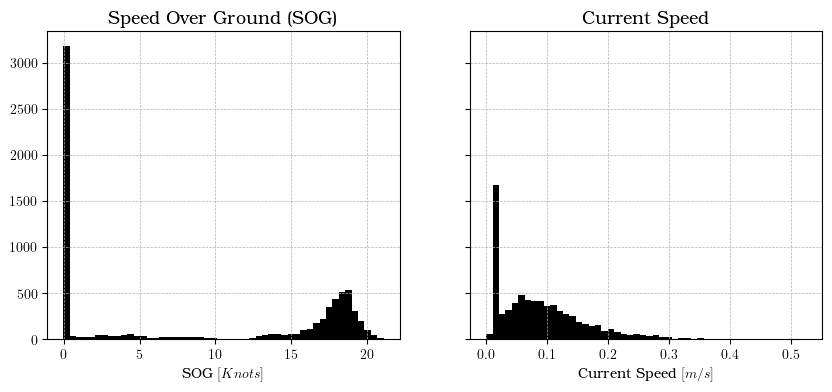

In [4]:
# Anomalies plot

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
dfmain['SOG'].hist(bins=50,color='black')
# Parameter to plot in nice latex fonts
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
plt.grid(linestyle = '--', linewidth = 0.5)
plt.xlabel(r"SOG $[Knots]$")
plt.title(r"Speed Over Ground (SOG)", fontsize=13)
plt.sca(axes[1])
dfmain['Current Speed'].hist(bins=50,color='black')
# Parameter to plot in nice latex fonts
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
plt.grid(linestyle = '--', linewidth = 0.5)
plt.xlabel(r"Current Speed $[m/s]$")
plt.title(r"Current Speed", fontsize=13)
plt.ylabel("")
plt.show()

Calculation of ship's true north wind and current direction

In [5]:
dfpre = dfpre.drop(dfpre.columns[[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,26]],axis=1)
dfpre = dfpre.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 
dfpre.head(n=5)

,eastwind,northwind,eastcurrent,northcurrent,sog,cog
0,2.267688,6.741482,0.113690,0.044994,0.0,358.9
1,1.782681,6.410275,0.113690,0.044994,0.0,358.9
2,1.154659,6.385135,0.083984,0.054000,0.0,358.9
3,0.348801,6.094659,0.083984,0.054000,0.0,358.9
4,-0.593128,6.153186,0.083984,0.054000,0.0,358.9


In [6]:
# Imputing the information for the missing east and north current data

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(dfpre)

KNNImputer(n_neighbors=50)

In [7]:
x_pre = imputer.transform(dfpre)

In [8]:
dfpre = pd.DataFrame(x_pre, columns=dfpre.columns, index=dfpre.index)

In [9]:
# Calculate current and wind speed

dfpre["Current Speed"] = np.sqrt(dfpre["eastcurrent"]**2 + dfpre["northcurrent"]**2)
dfpre["Wind Speed"] = np.sqrt(dfpre["eastwind"]**2 + dfpre["northwind"]**2)

In [10]:
# Calculate the True North wind direction and split them into quadrants

condwind = [(dfpre['eastwind']>0) & (dfpre['northwind']<0),
            (dfpre['eastwind']<0) & (dfpre['northwind']>0),
            (dfpre['eastwind']>0) & (dfpre['northwind']>0)]

choicewind = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"])))]

dfpre["True North Wind Direction"] = np.select(condwind, choicewind, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))))

In [11]:
# Calculate the True North current direction and split them into quadrants

condcurr = [(dfpre['eastcurrent']<0) & (dfpre['northcurrent']>0),
            (dfpre['eastcurrent']>0) & (dfpre['northcurrent']<0),
            (dfpre['eastcurrent']<0) & (dfpre['northcurrent']<0)]

choicecurr = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"])))]

dfpre["True North Current Direction"] = np.select(condcurr, choicecurr, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))))

In [12]:
dfpre.describe()

,eastwind,northwind,eastcurrent,northcurrent,sog,cog,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
count,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000
mean,1.976344,0.379926,0.019228,0.004214,8.870751,242.699284,0.096788,6.513813,198.585961,150.634332
std,5.296850,4.429899,0.089903,0.074041,8.619512,108.555287,0.067697,3.048934,92.310964,100.306234
min,-15.216397,-12.824582,-0.491010,-0.404690,-0.009130,-0.134241,0.000735,0.193221,0.052191,0.102997
25%,-1.756650,-2.534061,-0.021486,-0.033055,0.000000,124.116508,0.047447,4.149883,139.632096,73.919853
50%,2.294543,0.385690,0.025485,0.003718,6.953578,283.216008,0.079148,6.285080,205.028650,121.289202
75%,5.838650,3.339456,0.062644,0.039626,18.014436,346.200000,0.128444,8.525129,275.302728,227.423990
max,16.338177,14.519458,0.522374,0.364966,21.070514,359.728115,0.525174,16.760001,359.892603,359.958291


In [13]:
dfpre = dfpre.drop(['eastwind','northwind','eastcurrent','northcurrent','sog','cog'],axis=1)

In [14]:
# Drop the wind speed and current speed from the original dataset as it contains outlier 

dfmain = dfmain.drop(['Wind Speed','Current Speed'],axis=1)

In [15]:
df = pd.concat([dfmain,dfpre],axis=1)
df.head()

,Unnamed: 0,Time,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
0,0,2021-01-01 00:00:00,14.689663,55.098452,277.311035,1.259323,1.893614,4.818881,3.818459,4.154329,...,174.0,155.408180,105.591753,22.854050,22.749664,22.610062,0.122270,7.112664,251.408180,68.408246
1,1,2021-01-01 01:00:00,14.689659,55.098451,277.328369,1.259985,1.752303,4.755800,3.470216,4.130580,...,174.0,158.458891,105.591753,26.122772,19.152008,22.209274,0.122270,6.653538,254.458891,68.408246
2,2,2021-01-01 02:00:00,14.689648,55.098468,277.390625,1.260244,1.619775,4.645083,3.259682,4.083755,...,174.0,163.749663,116.740448,28.498383,12.424912,20.857971,0.099846,6.488697,259.749663,57.259552
3,3,2021-01-01 03:00:00,14.689646,55.098471,277.411377,1.260148,1.518736,4.588384,3.177906,4.010502,...,174.0,170.724504,116.740448,29.956985,6.725922,18.732071,0.099846,6.104632,266.724504,57.259552
4,4,2021-01-01 04:00:00,14.689644,55.098462,277.430664,1.260634,1.455034,4.528841,3.281654,3.913362,...,174.0,179.505940,116.740448,34.486298,3.761627,15.731430,0.099846,6.181707,174.494060,57.259552


In [16]:
# SOG threshold according to Abebe20 and Yan21

df = df[df['SOG'] > 5 ]

In [17]:
# Exclude data for the month of June to check the model's forecasting performance 
dfdate6 = df[df['Time'].dt.strftime('%Y-%m') == '2021-06']
df = df[df['Time'].dt.strftime('%Y-%m') != '2021-06']

In [18]:
# Temporary export
# df.to_csv("AIS_sog_threshold.csv")

In [19]:
# Temporary export
# df.to_csv("AIS_impute_check.csv")

Data Analysis before modelling 

In [20]:
df_ship = df.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
                    'Surface pressure','Width','Length'],axis=1)
df_ship.head(n=5)

,Temperature above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,Combined wind waves and swell height,Swell height,Wind wave height,Draught,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
8,276.900391,1.661038,4.291309,3.667458,3.757862,279.699585,0.865413,0.323892,0.801956,5.017723,...,269.900574,91.133175,143.029898,82.454986,91.138748,90.495209,0.104064,7.648595,268.966251,52.930471
9,276.705566,1.501637,4.187211,3.145607,3.803910,279.820312,0.785675,0.452440,0.578049,5.019207,...,300.130435,68.884377,96.351303,134.548587,115.015200,120.971331,0.104050,6.700397,260.985188,36.481737
10,276.309815,1.235528,4.012717,2.120399,3.819602,NaN,0.654636,0.556525,0.236435,5.019664,...,230.117302,129.989203,174.697284,59.296837,47.905998,52.498604,0.092759,4.089472,269.893495,44.814586
11,276.399902,1.204397,4.020009,2.090308,3.820546,NaN,0.638782,0.555405,0.226181,5.019009,...,178.653615,170.879672,107.951765,8.221531,10.314571,1.236454,0.093128,3.821501,262.226057,70.701850
12,277.134033,1.275907,4.095175,3.029945,3.815268,279.820312,0.674081,0.598373,0.263031,5.020452,...,125.446296,102.327505,72.665715,47.977150,68.470208,54.270195,0.086621,5.479353,246.881208,52.780582


In [21]:
df_ship2 = df_ship.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [22]:
df_ship2 = df_ship2[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

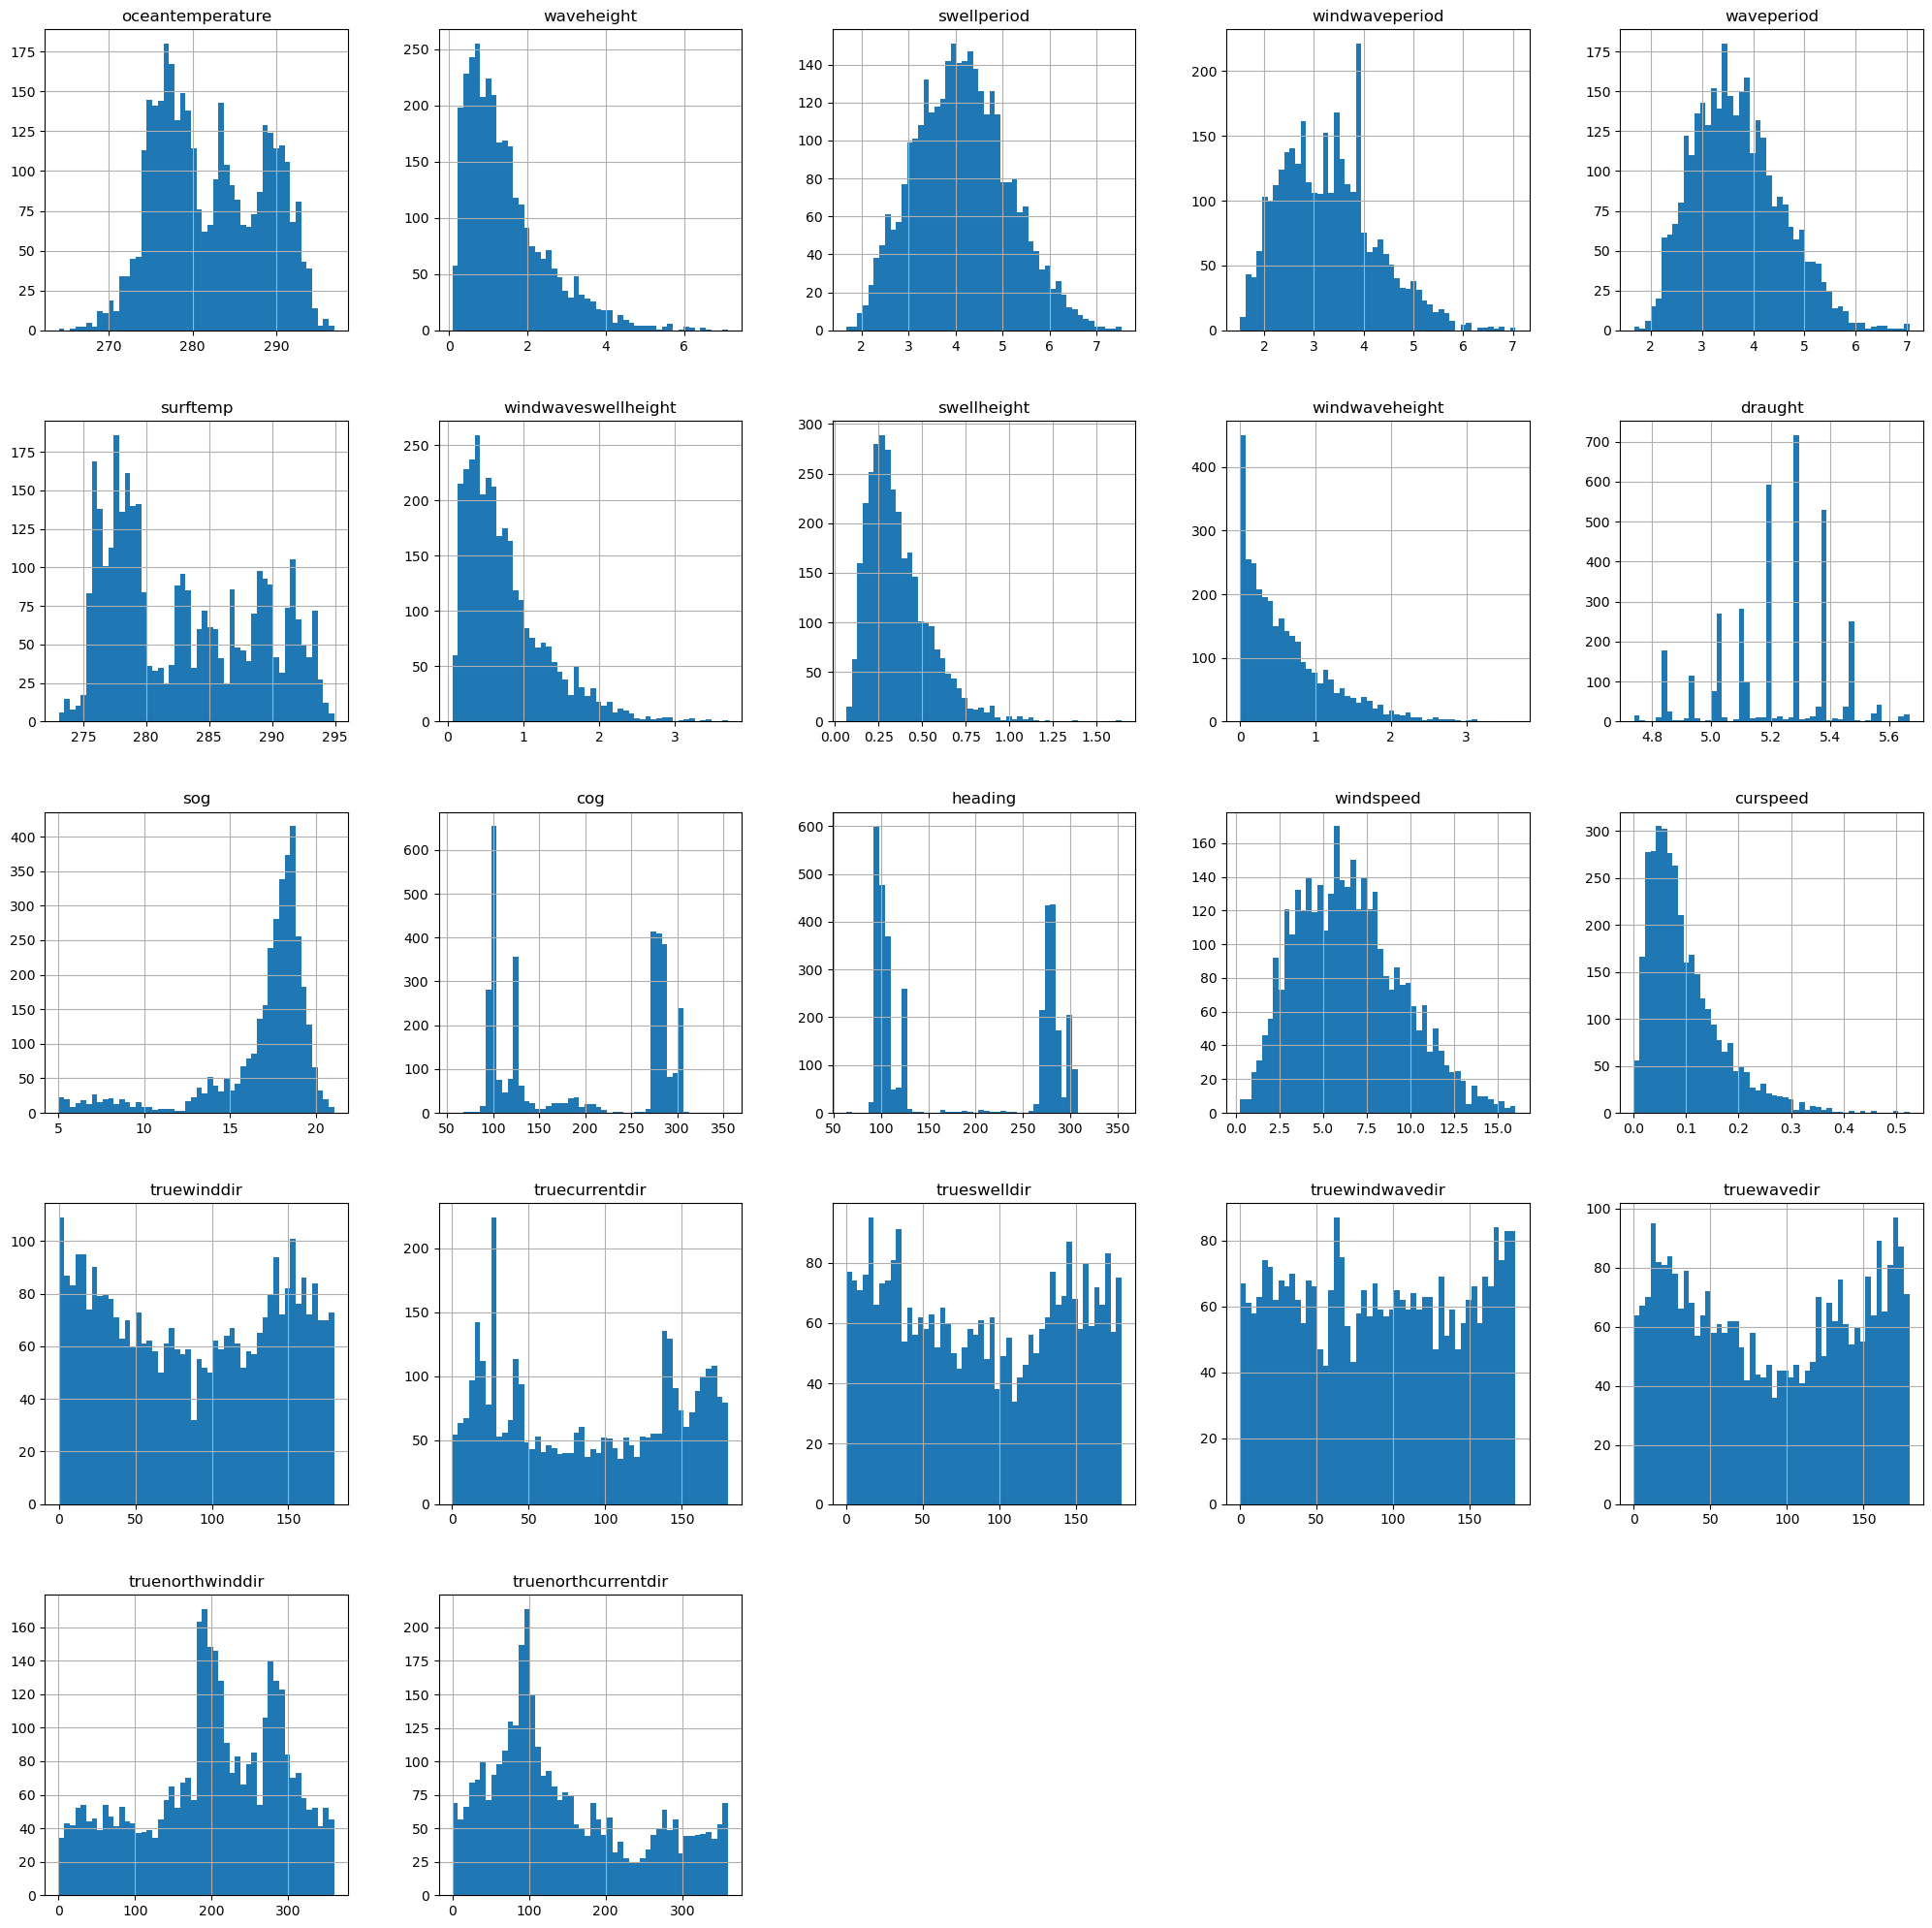

In [23]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault) # Alter default value 
df_ship2.hist(bins=50,figsize=(25,25))

plt.show()

Feature Selection

In [24]:
corr_matrix = df_ship2.corr()
print(corr_matrix["sog"])

oceantemperature       0.066226
waveheight            -0.004305
swellperiod           -0.001119
windwaveperiod        -0.013876
waveperiod             0.002105
surftemp               0.031413
windwaveswellheight   -0.003199
swellheight           -0.020481
windwaveheight        -0.000675
draught                0.148754
sog                    1.000000
cog                    0.016333
heading                0.213539
windspeed              0.117765
curspeed               0.137821
truewinddir            0.063382
truecurrentdir         0.147950
trueswelldir           0.001415
truewindwavedir       -0.003321
truewavedir           -0.006828
truenorthwinddir      -0.022305
truenorthcurrentdir    0.106215
Name: sog, dtype: float64


In [25]:
dfship_corr = df_ship2.drop(df_ship2.columns[[0,5,15,16,17,18,19,20,21]],axis=1)
dfship_corr.head()

,waveheight,swellperiod,windwaveperiod,waveperiod,windwaveswellheight,swellheight,windwaveheight,draught,sog,cog,heading,windspeed,curspeed
8,1.661038,4.291309,3.667458,3.757862,0.865413,0.323892,0.801956,5.017723,14.578394,299.573513,269.900574,7.648595,0.104064
9,1.501637,4.187211,3.145607,3.803910,0.785675,0.452440,0.578049,5.019207,18.148696,302.274508,300.130435,6.700397,0.104050
10,1.235528,4.012717,2.120399,3.819602,0.654636,0.556525,0.236435,5.019664,9.686510,163.922318,230.117302,4.089472,0.092759
11,1.204397,4.020009,2.090308,3.820546,0.638782,0.555405,0.226181,5.019009,11.252112,117.003285,178.653615,3.821501,0.093128
12,1.275907,4.095175,3.029945,3.815268,0.674081,0.598373,0.263031,5.020452,18.119627,125.829385,125.446296,5.479353,0.086621


In [26]:
def correlation_heatmap(df,fontsize):
    correlations = df.corr()
    # Parameter to plot in nice latex fonts
    plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
    colormap = sns.color_palette("Reds")
    fig, ax = plt.subplots(figsize=(10,10))
    sns.set(font_scale = fontsize)
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',cmap="mako",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
                # ,annot_kws={'fontsize': 12, 'color':'k', 'alpha': 1})
    plt.show();

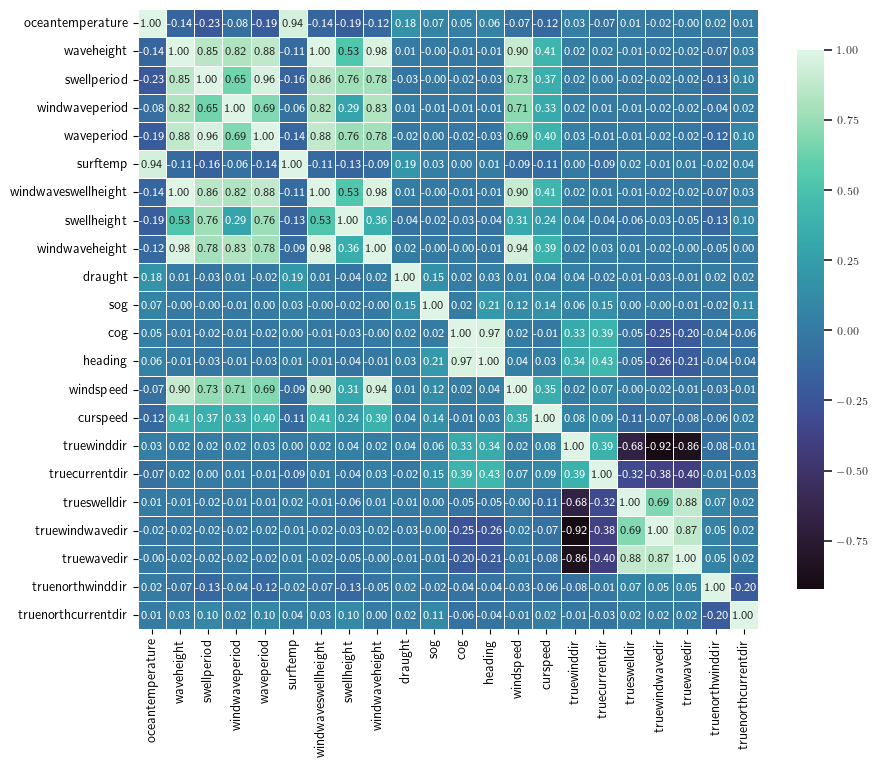

In [27]:
df_ship_ovr = df_ship2
correlation_heatmap(df_ship_ovr,.7)

Scientific Justification of HCF:

-According to Bitner Gregersen, the wind wave swell height is equal to the square root of the square of swell wave and wind wave. Therefore SWH and WWH is to be dropped.<br>
-According to Mori, through wave spectrum, the maximum wave height can be approximated, therefore max wave height can be dropped as well <br>
-According to Torsetshaugen, The type of dominating wave (Wind wave/Swell) can be predicted from the significant through an equation which include the significant wave height and a certain threshold, therefore, it is decided that the wind wave period, swell period and consequently the true wind wave direction and true swell direction is to be dropped.<br>
-Drop The True Wind and True North direction and replace with the True North direction
- Update 24/6 : Decision reverted to drop true directions

In [28]:
df_ship2 = df_ship2.drop(['waveheight','swellheight','windwaveheight',
                        'windwaveperiod','swellperiod',
                        'truewindwavedir','trueswelldir',
                        'truenorthcurrentdir','truenorthwinddir'],axis=1)

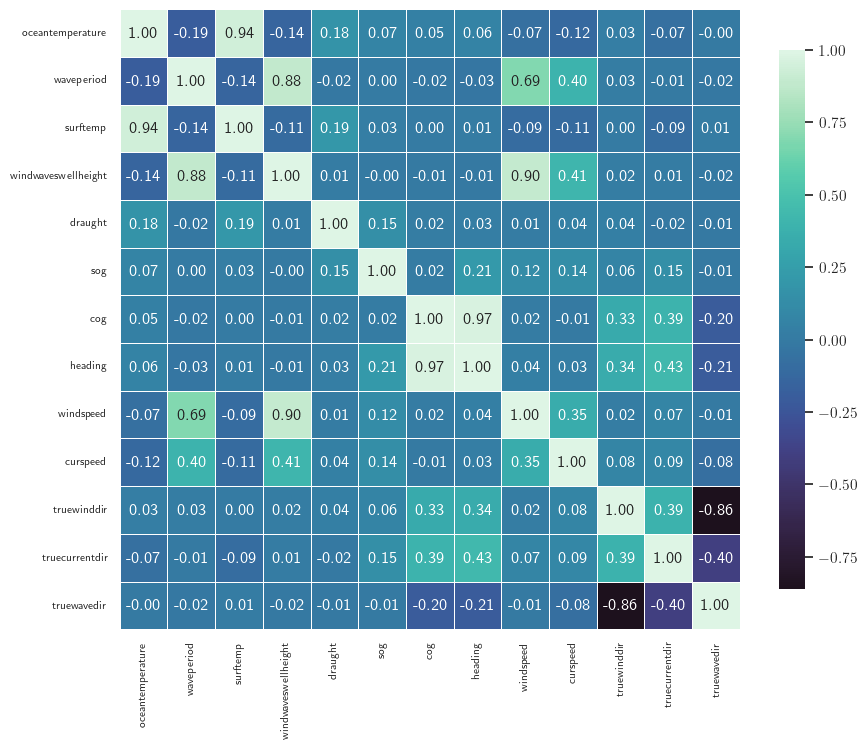

In [29]:
correlation_heatmap(df_ship2,1)

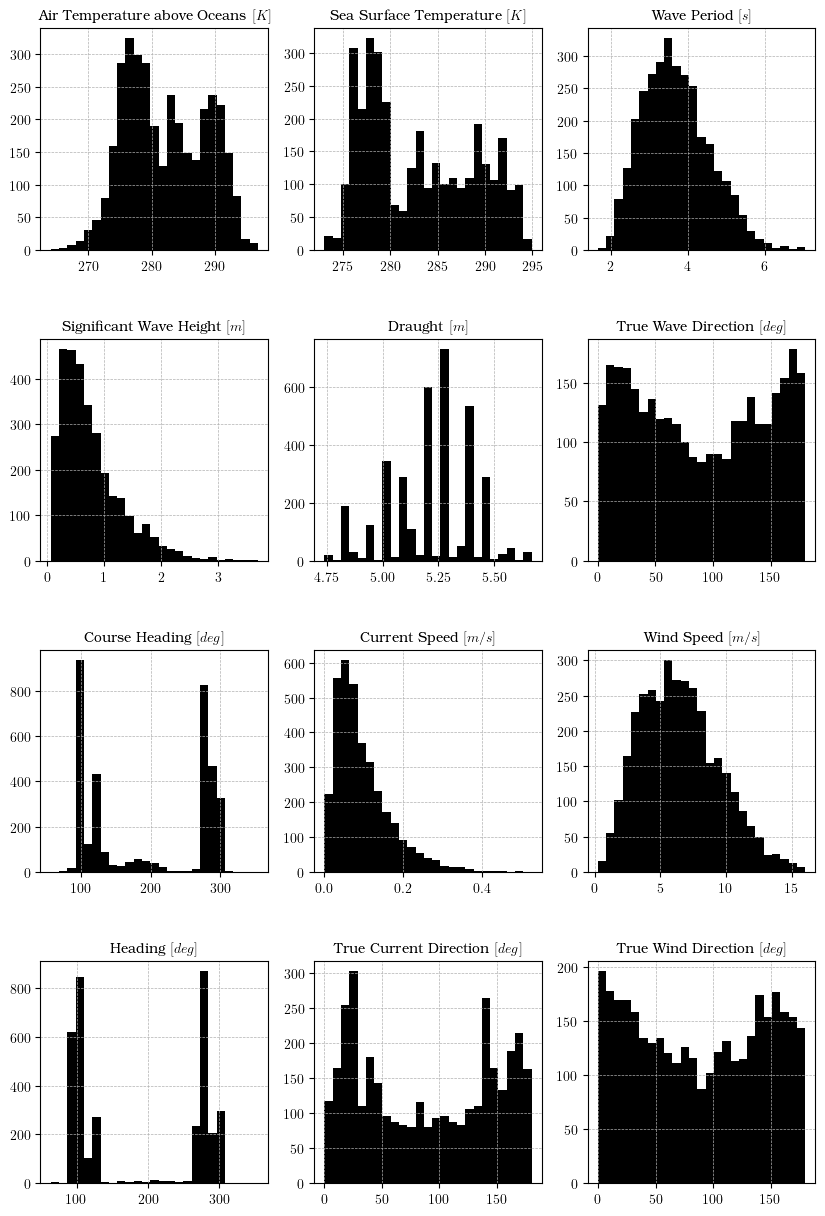

In [30]:
# demonstrate how to toggle the display of different elements:
# Histogram plot of final features and labels for training

fs = 10

plt.rcParams.update(plt.rcParamsDefault)
# Parameter to plot in nice latex fonts
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})

oceantemp = df_ship2['oceantemperature']
waveperiod = df_ship2['waveperiod']
surftemp = df_ship2['surftemp']
sigwave = df_ship2['windwaveswellheight']
draught = df_ship2['draught']
sog = df_ship2['sog']
cog = df_ship2['cog']
hdg = df_ship2['heading']
windspeed = df_ship2['windspeed']
curspeed = df_ship2['curspeed']
truewavedir = df_ship2['truewavedir']
truewind = df_ship2['truewinddir']
truecurrent = df_ship2['truecurrentdir']

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 15))

axes[0, 0].hist(oceantemp,bins=25,color='black')
axes[0, 0].set_title(r'Air Temperature above Oceans $[K]$', fontsize=fs)
axes[0, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[0, 1].hist(surftemp,bins=25,color='black')
axes[0, 1].set_title(r'Sea Surface Temperature $[K]$', fontsize=fs)
axes[0, 1].grid(True,linestyle = '--', linewidth = 0.5)

axes[0, 2].hist(waveperiod,bins=25,color='black')
axes[0, 2].set_title(r'Wave Period $[s]$', fontsize=fs)
axes[0, 2].grid(True,linestyle = '--', linewidth = 0.5)

axes[1, 0].hist(sigwave,bins=25,color='black')
axes[1, 0].set_title(r'Significant Wave Height $[m]$', fontsize=fs)
axes[1, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[1, 1].hist(draught  ,bins=25,color='black')
axes[1, 1].set_title(r'Draught $[m]$', fontsize=fs)
axes[1, 1].grid(True,linestyle = '--', linewidth = 0.5)

axes[1, 2].hist(truewavedir,bins=25,color='black')
axes[1, 2].set_title(r'True Wave Direction $[deg]$', fontsize=fs)
axes[1, 2].grid(True,linestyle = '--', linewidth = 0.5)

axes[2, 0].hist(cog,bins=25,color='black')
axes[2, 0].set_title(r'Course Heading $[deg]$', fontsize=fs)
axes[2, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[2, 1].hist(curspeed,bins=25,color='black')
axes[2, 1].set_title(r'Current Speed $[m/s]$', fontsize=fs)
axes[2, 1].grid(True,linestyle = '--', linewidth = 0.5)

axes[2, 2].hist(windspeed,bins=25,color='black')
axes[2, 2].set_title(r'Wind Speed $[m/s]$', fontsize=fs)
axes[2, 2].grid(True,linestyle = '--', linewidth = 0.5)

axes[3, 0].hist(hdg,bins=25,color='black')
axes[3, 0].set_title(r'Heading $[deg]$', fontsize=fs)
axes[3, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[3, 1].hist(truecurrent,bins=25,color='black')
axes[3, 1].set_title(r'True Current Direction $[deg]$', fontsize=fs)
axes[3, 1].grid(True,linestyle = '--', linewidth = 0.5)

axes[3, 2].hist(truewind,bins=25,color='black')
axes[3, 2].set_title(r'True Wind Direction $[deg]$', fontsize=fs)
axes[3, 2].grid(True,linestyle = '--', linewidth = 0.5)

fig.subplots_adjust(hspace=0.4)
plt.show()

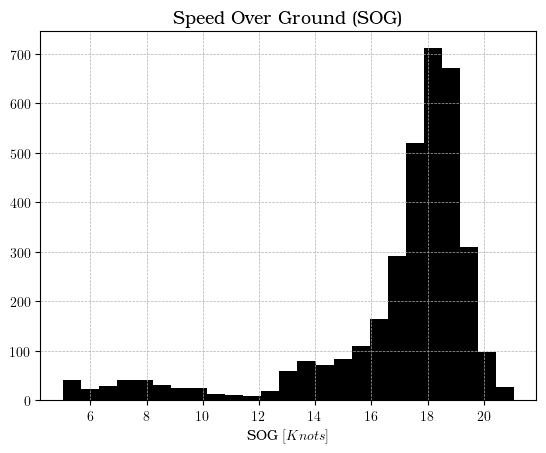

In [31]:
df_ship2['sog'].hist(bins=25,color='black')
# Parameter to plot in nice latex fonts
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
plt.grid(linestyle = '--', linewidth = 0.5)
plt.xlabel(r"SOG $[Knots]$")
plt.title(r"Speed Over Ground (SOG)", fontsize=13)
plt.show()

Imputing using KNN so that the Random Forest Regressor may function <br>
RFR cannot accept nan values <br>
Imputed data is then transformed

In [32]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(df_ship2)


KNNImputer(n_neighbors=50)

In [33]:
X = imputer.transform(df_ship2)

In [34]:
df_ship2tr = pd.DataFrame(X, columns=df_ship2.columns, index=df_ship2.index)

In [35]:
print(df_ship2tr.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3506 entries, 8 to 7976
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oceantemperature     3506 non-null   float64
 1   waveperiod           3506 non-null   float64
 2   surftemp             3506 non-null   float64
 3   windwaveswellheight  3506 non-null   float64
 4   draught              3506 non-null   float64
 5   sog                  3506 non-null   float64
 6   cog                  3506 non-null   float64
 7   heading              3506 non-null   float64
 8   windspeed            3506 non-null   float64
 9   curspeed             3506 non-null   float64
 10  truewinddir          3506 non-null   float64
 11  truecurrentdir       3506 non-null   float64
 12  truewavedir          3506 non-null   float64
dtypes: float64(13)
memory usage: 383.5 KB
None


Data Split for training and test data

In [36]:
# Implement the Random forest, but first, data is to be split into training and validation data

from sklearn.model_selection import train_test_split
import time 

# Dropping some feature can be done here to (possibly) increase the model's performance 
x_train,x_test,y_train,y_test = train_test_split(df_ship2tr.drop(['sog',]
                                                                 ,axis=1)
                                                                ,df_ship2tr.sog,test_size=0.2,random_state=42)


In [37]:
print("Amount of the x training dataset is:",len(x_train))

Amount of the x training dataset is: 2804


In [38]:
x_train.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir
count,2804.000000,2804.000000,2804.000000,2804.000000,2804.000000,2804.000000,2804.000000,2804.000000,2804.000000,2804.000000,2804.000000,2804.000000
mean,282.263483,3.686358,283.065302,0.763475,5.219027,197.225488,188.619169,6.490484,0.096608,89.066716,90.647545,89.315851
std,6.293702,0.826939,5.679579,0.520783,0.181266,86.202838,88.762608,2.995040,0.070568,55.824273,57.629557,55.212635
min,265.853058,1.672565,273.048584,0.065236,4.739825,56.023445,63.486661,0.345946,0.000980,0.000973,0.248414,0.055169
25%,277.072571,3.100376,277.986939,0.389226,5.109236,102.575964,100.864812,4.162302,0.045857,35.594343,32.317059,37.737208
50%,281.567017,3.613781,282.489368,0.642599,5.199793,190.643117,124.797960,6.241934,0.077188,90.798494,91.790516,86.378869
75%,288.091492,4.162072,288.422028,0.949364,5.375120,282.458627,279.529266,8.358693,0.128302,141.609065,144.359026,140.230983
max,296.830322,7.047197,294.928223,3.698143,5.667030,355.065691,354.145635,16.010816,0.525174,179.858625,179.997073,179.830612


In [39]:
y_train.describe()

count    2804.000000
mean       16.871671
std         3.138638
min         5.027200
25%        16.543623
50%        17.924212
75%        18.660957
max        21.070514
Name: sog, dtype: float64

In [40]:
print("Amount of the test dataset is",len(x_test))

Amount of the test dataset is 702


In [41]:
y_test.describe()

count    702.000000
mean      16.942633
std        3.252179
min        5.087138
25%       16.748862
50%       17.971528
75%       18.747138
max       20.943915
Name: sog, dtype: float64

Test for "unreasonable effectiveness of data"

In [42]:
df_ship6 = dfdate6.drop(['Unnamed: 0','LON','LAT','Time','Air density above oceans',
                    'Surface pressure','Width','Length'],axis=1)
df_ship6.head(n=5)

,Temperature above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,Combined wind waves and swell height,Swell height,Wind wave height,Draught,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
119,275.823975,3.358080,6.738089,4.925452,5.291555,278.661621,1.759765,0.743164,1.583740,5.281861,...,100.782313,100.989288,164.871808,15.554049,66.843493,57.268527,0.144914,10.248966,21.771601,184.345879
120,275.924011,3.578120,7.185143,5.342444,5.697814,278.936035,1.950242,0.841925,1.757568,5.289403,...,96.934816,108.737155,153.650411,11.071672,60.455881,51.313932,0.246220,11.364678,25.671971,199.414773
121,276.285034,4.184914,7.260825,5.460486,6.126474,279.209961,2.189788,0.933936,1.910706,5.288446,...,97.525758,114.910729,153.031589,16.281358,57.086511,46.894106,0.284315,12.666946,32.436488,199.442652
122,277.189484,4.908680,6.808745,6.225745,6.284671,279.216553,2.565230,0.723303,2.452637,5.290781,...,106.941521,123.568984,153.643227,69.175152,55.507286,56.527939,0.300428,13.386999,50.510505,189.415252
126,277.408752,4.621826,6.813305,5.970984,6.291378,279.319824,2.414834,1.022894,2.130981,4.842367,...,227.680837,26.476633,41.766758,158.632374,159.050718,167.192888,0.262897,12.053293,74.157471,180.552404


In [43]:
df_ship6_rn = df_ship6.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [44]:
df_ship6_rn = df_ship6_rn[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

In [45]:
df_ship6_rn = df_ship6_rn.drop(['waveheight','swellheight','windwaveheight',
                        'windwaveperiod','swellperiod',
                        'truewindwavedir','trueswelldir',
                        'truenorthcurrentdir','truenorthwinddir'],axis=1)

In [46]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(df_ship6_rn)

KNNImputer(n_neighbors=50)

In [47]:
X6 = imputer.transform(df_ship6_rn)

In [48]:
df_ship6tr = pd.DataFrame(X6, columns=df_ship6_rn.columns, index=df_ship6_rn.index)

In [49]:
x_months6 = df_ship6tr.drop(['sog'],axis=1)
y_months6 = df_ship6tr.sog

In [50]:
print("Amount of the test dataset is:",len(x_months6))

Amount of the test dataset is: 322


Concatenate test and validation data

In [51]:
x_date_c = pd.concat([x_test,x_months6])
y_date_c = pd.concat([y_test,y_months6])

In [52]:
y_date_c.describe()

count    1024.000000
mean       17.102082
std         3.203170
min         5.087138
25%        16.700126
50%        18.055400
75%        18.955901
max        21.031230
Name: sog, dtype: float64

Modelling using Random Forest Regressor 

In [53]:
from sklearn.ensemble import RandomForestRegressor
model_rfr_ftr = RandomForestRegressor(random_state=42)
start_rf = time.time()
model_rfr_ftr.fit(x_train,y_train)
end_rf = time.time()
print(f"Training time: {end_rf-start_rf:0.4}s ")

Training time: 4.145s 


HPO RFR for validation data

In [54]:
from sklearn.ensemble import RandomForestRegressor
model_rfr_ftr_hpov = RandomForestRegressor(n_estimators = 100,
                                            min_samples_split = 2,
                                            min_samples_leaf = 1,
                                            max_features = 10,
                                            max_depth=120,
                                            random_state=42)

# # Prev HPO: (n_estimators = 900,min_samples_split = 2,min_samples_leaf = 2,# max_features = 9,max_depth=200,random_state=42)

start_rfo = time.time()
model_rfr_ftr_hpov.fit(x_train,y_train)
end_rfo = time.time()
print(f"Training time: {end_rfo-start_rfo:0.4}s ")

Training time: 3.497s 


Modelling using ETR

In [55]:
from sklearn.ensemble import ExtraTreesRegressor

model_etr = ExtraTreesRegressor(random_state=42)
start_et = time.time()
model_etr.fit(x_train,y_train)
end_et = time.time()
print(f"Training time: {end_et-start_et:0.4}s ")

Training time: 0.9528s 


HPO ETR for validation data

In [56]:
from sklearn.ensemble import ExtraTreesRegressor

model_etr_hpov = ExtraTreesRegressor(random_state=42,
                                n_estimators=800,
                                min_samples_split=9,
                                min_samples_leaf=1,
                                max_features=12,
                                max_depth=120,
                                )
# Prev HPO (random_state=42,n_estimators=600,max_depth=10)

start_eto = time.time()
model_etr_hpov.fit(x_train,y_train)
end_eto = time.time()
print(f"Training time: {end_eto-start_eto:0.4}s")

Training time: 4.438s


Modelling using Decision Tree Regressor

In [57]:
from sklearn.tree import DecisionTreeRegressor
model_dtr = DecisionTreeRegressor()
start_dtr = time.time()
model_dtr.fit(x_train,y_train)
end_dtr = time.time()
print(f"Training time: {end_dtr-start_dtr:0.4}s")

Training time: 0.04599s


HPO DTR for validation data

In [58]:
from sklearn.tree import DecisionTreeRegressor
model_dtr_hpov = DecisionTreeRegressor(min_samples_split=7,
                                  min_samples_leaf=10,
                                  max_features=12,
                                  max_depth=8)
# Old HPO (min_samples_split=2,min_samples_leaf=3,max_features=12,max_depth=10)
start_dtro = time.time()
model_dtr_hpov.fit(x_train,y_train)
end_dtro = time.time()
print(f"Training time: {end_dtro-start_dtro:0.4}s")

Training time: 0.022s


Modelling using Multiple Linear Regression

In [59]:
from sklearn import linear_model
model_mlr = linear_model.LinearRegression()
start_mlr = time.time()
model_mlr.fit(x_train,y_train)
end_mlr = time.time()
print(f"Training time: {end_mlr-start_mlr:0.4}s")

Training time: 0.005s


Save model to local directory

In [60]:
# # # Saving the model to local directory

# filename = 'savemodel_rfr_mod1.sav'
# joblib.dump(model_rfr_ftr,filename)

# filename = 'savemodel_rfr_mod1_hpov.sav'
# joblib.dump(model_rfr_ftr_hpov,filename)

# filename = 'savemodel_etr_mod1.sav'
# joblib.dump(model_etr,filename)

# filename = 'savemodel_etr_hpov_mod1.sav'
# joblib.dump(model_etr_hpov,filename)

# filename = 'savemodel_dtr_ftr_mod1.sav'
# joblib.dump(model_dtr,filename)

# filename = 'savemodel_dtr_hpov_mod1.sav'
# joblib.dump(model_dtr_hpov,filename)

# filename = 'savemodel_mlr_ftr_mod1.sav'
# joblib.dump(model_mlr,filename)

['savemodel_mlr_ftr_mod1.sav']

Model Evaluation

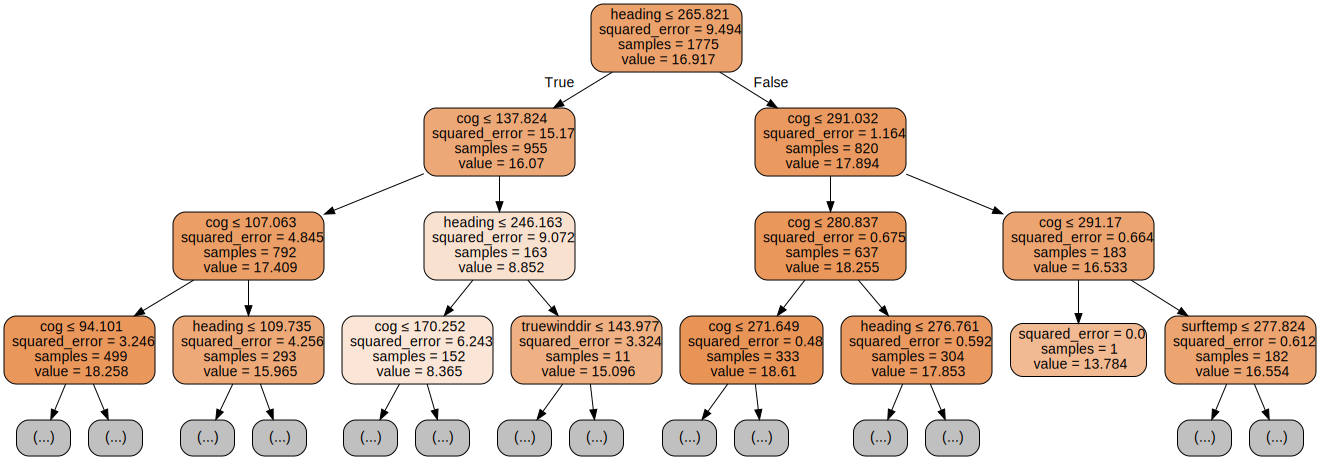

In [ ]:
# Plot tree using graphviz, generate 2nd tree in forest

from IPython.display import display
from sklearn import tree
import graphviz

dot_data2 = tree.export_graphviz(model_rfr_ftr.estimators_[2], 
                  feature_names=x_train.columns.values.tolist(),  
                #   class_names=class_names,  
                  filled=True, rounded=True,  
                  special_characters=True,
                   out_file=None,
                   max_depth=3,
                           )

display(graphviz.Source(dot_data2))

# # Only uncomment when about to generate PNG file, it will create source file that cannot be ignored by git

# graph = graphviz.Source(dot_data2)
# graph.format = 'png'
# graph.render('rf_tree_test_it2',view=True)

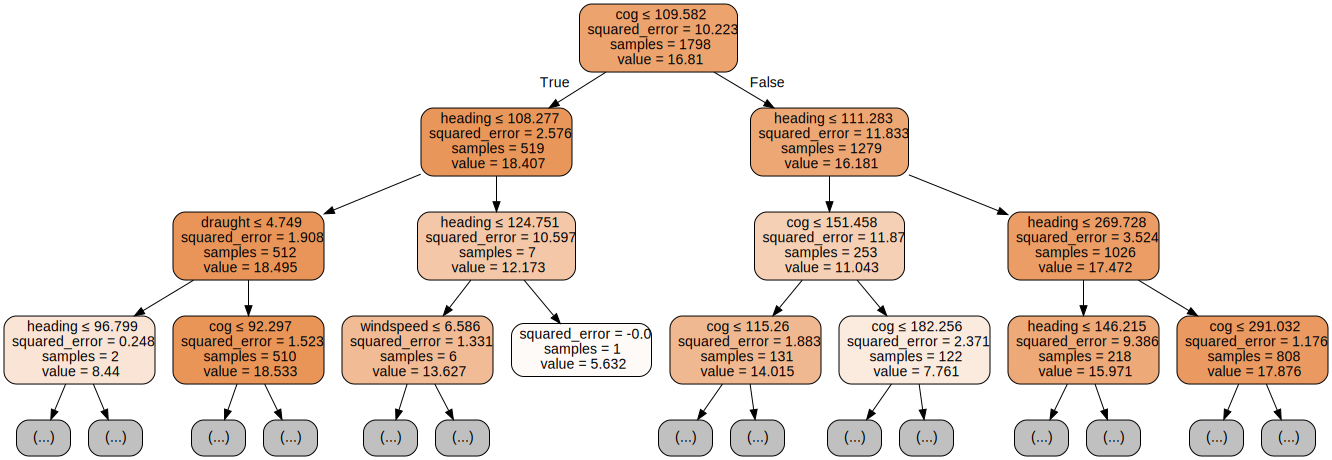

In [ ]:
# Generate 5th tree in forest

dot_data5 = tree.export_graphviz(model_rfr_ftr.estimators_[5], 
                  feature_names=x_train.columns.values.tolist(),  
                #   class_names=class_names,  
                  filled=True, rounded=True,  
                  special_characters=True,
                   out_file=None,
                   max_depth=3,
                           )

display(graphviz.Source(dot_data5))

# # Only uncomment when about to generate PNG file, it will create source file that cannot be ignored by git

# graph = graphviz.Source(dot_data5)
# graph.format = 'png'
# graph.render('rf_tree_test_it5',view=True)

In [ ]:
def model_importance(model_type):
    mod_imp = model_type.feature_importances_
    df_mod_imp = pd.DataFrame(mod_imp,index= x_train.columns,columns=["Importance"])
    print(df_mod_imp.sort_values(by=['Importance'],ascending=False))


In [ ]:
def plot_feature_importance(model_type,names,model_name):

    importance = model_type.feature_importances_

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(5,4))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'],color='black')
    #Add chart labels
    plt.title(f"Feature Importance of {model_name}")
    plt.grid(linestyle = '--', linewidth = 0.4,axis='x')
    plt.xlabel('Feature Importance')
    plt.xlim(0,0.7)
    plt.ylabel('Feature Names')


                     Importance
cog                    0.468258
heading                0.451966
draught                0.023961
truecurrentdir         0.007656
curspeed               0.007361
surftemp               0.006754
windwaveswellheight    0.006095
windspeed              0.005768
oceantemperature       0.005729
waveperiod             0.005672
truewavedir            0.005420
truewinddir            0.005361


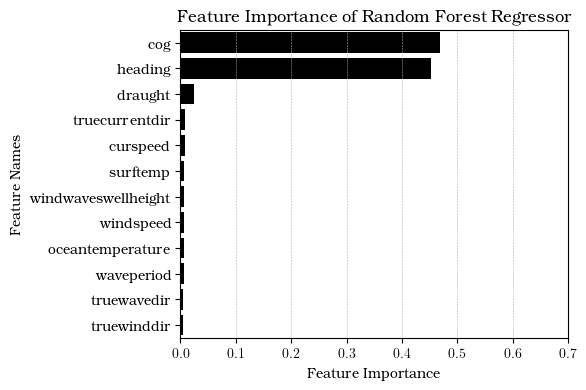

In [ ]:
model_importance(model_rfr_ftr)
plot_feature_importance(model_rfr_ftr,x_train.columns,'Random Forest Regressor')
plt.show()


                     Importance
cog                    0.616863
heading                0.268000
draught                0.021204
truecurrentdir         0.019883
windwaveswellheight    0.012447
curspeed               0.011722
waveperiod             0.011568
windspeed              0.009407
truewavedir            0.007859
surftemp               0.007631
oceantemperature       0.007222
truewinddir            0.006193


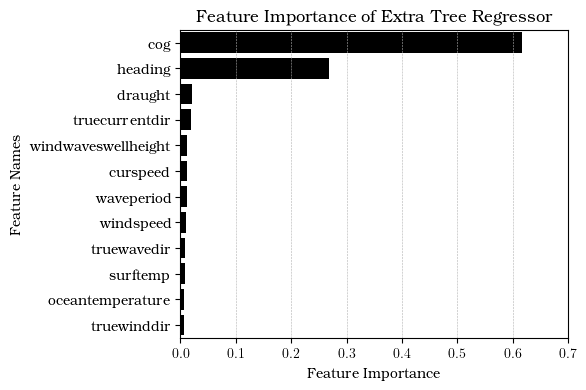

In [ ]:
model_importance(model_etr)
plot_feature_importance(model_etr,x_train.columns,'Extra Tree Regressor')
plt.show()

                     Importance
heading                0.607082
cog                    0.311020
draught                0.020056
windspeed              0.012800
truecurrentdir         0.009740
truewavedir            0.007460
surftemp               0.007255
windwaveswellheight    0.005862
curspeed               0.005680
truewinddir            0.004584
oceantemperature       0.004546
waveperiod             0.003915


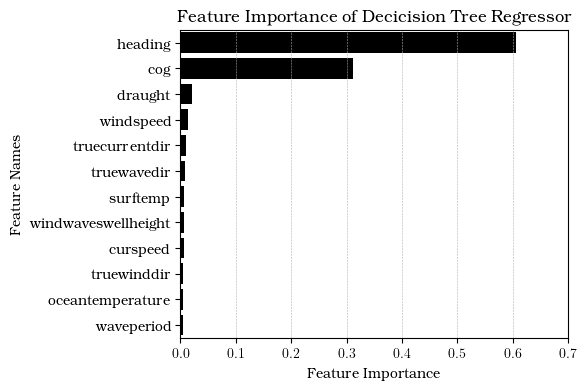

In [ ]:
model_importance(model_dtr)
plot_feature_importance(model_dtr,x_train.columns,'Decicision Tree Regressor')
plt.show()

In [ ]:
def evaluate(model, features_x, labels_y):
    from sklearn.model_selection import cross_val_score

    score_r2 = cross_val_score(model,features_x,labels_y,
                           scoring='r2',cv=10)
    rsquared = score_r2.mean()
    stadev_rsquared = score_r2.std()
    max_rsquared = score_r2.max()
    min_rsquared = score_r2.min()

    score_expVar = cross_val_score(model,features_x,labels_y,
                           scoring='explained_variance',cv=10)
    expVar = score_expVar.mean()
    stadev_expVar = score_expVar.std()
    max_expVar = score_expVar.max()
    min_expVar = score_expVar.min()

    score_MAE = cross_val_score(model,features_x,labels_y,
                           scoring='neg_mean_absolute_error',cv=10)
    MAE = -score_MAE.mean()
    stadev_MAE = score_MAE.std()
    max_MAE = -score_MAE.max()
    min_MAE = -score_MAE.min()

    score_MAD = cross_val_score(model,features_x,labels_y,
                           scoring='neg_median_absolute_error',cv=10)
    MAD = -score_MAD.mean()
    stadev_MAD = score_MAD.std()
    max_MAD = -score_MAD.max()
    min_MAD = -score_MAD.min()



    score_RMSE = cross_val_score(model,features_x,labels_y,
                           scoring='neg_root_mean_squared_error',cv=10)
    RMSE = -score_RMSE.mean()
    stadev_RMSE = score_RMSE.std()
    max_RMSE = -score_RMSE.max()
    min_RMSE = -score_RMSE.min()


    print(f"Model Performance of {model}")
    print(f"R^2 = {rsquared:0.4f}, std = {stadev_rsquared:0.4f}, max = {max_rsquared:0.4f}, min = {min_rsquared:0.4f}")
    print(f"explained Variance = {expVar:0.4f}, std = {stadev_expVar:0.4f}, max = {max_expVar:0.4f}, min = {min_expVar:0.4f}")
    print(f"MAE = {MAE:0.4f}, std = {stadev_MAE:0.4f}, max = {max_MAE:0.4f}, min = {min_MAE:0.4f}")
    print(f"RMSE = {RMSE:0.4f}, std = {stadev_RMSE:0.4f}, max = {max_RMSE:0.4f}, min = {min_RMSE:0.4f}")
    print(f"MAD = {MAD:0.4f}, std = {stadev_MAD:0.4f}, max = {max_MAD:0.4f}, min = {min_MAD:0.4f}\n")

    return score_r2,score_expVar,score_MAE,score_MAD,score_RMSE        

Evaluation of RFR

In [ ]:
r2_rf,expVar_rf,MAE_rf,RMSE_rf,MAD_rf = evaluate(model_rfr_ftr,x_train,y_train)

Model Performance of RandomForestRegressor(random_state=42)
R^2 = 0.8601, std = 0.0587, max = 0.9465, min = 0.7232
explained Variance = 0.8619, std = 0.0583, max = 0.9467, min = 0.7239
MAE = 0.7656, std = 0.1108, max = 0.5154, min = 0.9063
RMSE = 1.1506, std = 0.2149, max = 0.6691, min = 1.4071
MAD = 0.5103, std = 0.0996, max = 0.3781, min = 0.6625



In [ ]:
# Evaluate performance of predictor for combined test and validation data 

# r2_rfc,expVar_rfc,MAE_rfc,RMSE_rfc,MAD_rfc = evaluate(model_rfr_ftr,x_date_c,y_date_c)

Model Performance of RandomForestRegressor(random_state=42)
R^2 = 0.8838, std = 0.0481, max = 0.9472, min = 0.8117
explained Variance = 0.8888, std = 0.0438, max = 0.9491, min = 0.8173
MAE = 0.7227, std = 0.1284, max = 0.5439, min = 0.9347
RMSE = 1.0457, std = 0.1972, max = 0.7175, min = 1.3049
MAD = 0.5309, std = 0.1085, max = 0.4081, min = 0.7489



Evaluation of ETR

In [ ]:
r2_et,expVar_et,MAE_et,RMSE_et,MAD_et = evaluate(model_etr,x_train,y_train)

Model Performance of ExtraTreesRegressor(random_state=42)
R^2 = 0.9027, std = 0.0605, max = 0.9524, min = 0.7362
explained Variance = 0.9035, std = 0.0606, max = 0.9525, min = 0.7366
MAE = 0.6416, std = 0.0854, max = 0.4694, min = 0.8072
RMSE = 0.9407, std = 0.2054, max = 0.6312, min = 1.3671
MAD = 0.4452, std = 0.0812, max = 0.3449, min = 0.5812



In [ ]:
# Evaluate performance of predictor for combined test and validation data 

# r2_etc,expVar_etc,MAE_etc,RMSE_etc,MAD_etc = evaluate(model_etr,x_date_c,y_date_c)

Model Performance of ExtraTreesRegressor(random_state=42)
R^2 = 0.8988, std = 0.0407, max = 0.9503, min = 0.8243
explained Variance = 0.9025, std = 0.0403, max = 0.9509, min = 0.8243
MAE = 0.6869, std = 0.1081, max = 0.5334, min = 0.9125
RMSE = 0.9767, std = 0.1668, max = 0.6959, min = 1.2316
MAD = 0.5226, std = 0.0951, max = 0.4255, min = 0.7330



Evaluation of DTR

In [ ]:
r2_dt,expVar_dt,MAE_dt,RMSE_dt,MAD_dt = evaluate(model_dtr,x_train,y_train)

Model Performance of DecisionTreeRegressor()
R^2 = 0.5782, std = 0.3199, max = 0.8566, min = -0.1804
explained Variance = 0.5581, std = 0.2864, max = 0.8677, min = -0.0473
MAE = 1.1173, std = 0.2072, max = 0.8211, min = 1.5204
RMSE = 1.8605, std = 0.5059, max = 1.0446, min = 2.7802
MAD = 0.6521, std = 0.0909, max = 0.5239, min = 0.8223



In [ ]:
# Evaluate performance of predictor for combined test and validation data 

# r2_dtc,expVar_dtc,MAE_dtc,RMSE_dtc,MAD_dtc = evaluate(model_dtr,x_date_c,y_date_c)

Model Performance of DecisionTreeRegressor()
R^2 = 0.8199, std = 0.0535, max = 0.8851, min = 0.7224
explained Variance = 0.8233, std = 0.0531, max = 0.8897, min = 0.7304
MAE = 0.9396, std = 0.1097, max = 0.7322, min = 1.1213
RMSE = 1.3041, std = 0.1660, max = 1.0614, min = 1.5809
MAD = 0.6979, std = 0.1075, max = 0.4719, min = 0.8378



Evaluation of MLR 

In [ ]:
r2_mlr,expVar_mlr,MAE_mlr,RMSE_mlr,MAD_mlr = evaluate(model_mlr,x_train,y_train)

Model Performance of LinearRegression()
R^2 = 0.6414, std = 0.2779, max = 0.8771, min = -0.1362
explained Variance = 0.6464, std = 0.2752, max = 0.8821, min = -0.1206
MAE = 1.1483, std = 0.1785, max = 0.8240, min = 1.5124
RMSE = 1.7647, std = 0.4969, max = 1.0147, min = 2.8370
MAD = 0.9090, std = 0.1601, max = 0.6468, min = 1.1739



In [ ]:
# r2_mlrc,expVar_mlrc,MAE_mlrc,RMSE_mlrc,MAD_mlrc = evaluate(model_mlr,x_date_c,y_date_c)

Model Performance of LinearRegression()
R^2 = 0.6237, std = 0.2531, max = 0.8465, min = 0.0895
explained Variance = 0.6339, std = 0.2465, max = 0.8504, min = 0.1195
MAE = 1.2144, std = 0.2171, max = 0.9757, min = 1.6255
RMSE = 1.8181, std = 0.5104, max = 1.2235, min = 2.8865
MAD = 0.9734, std = 0.2192, max = 0.6618, min = 1.3878



In [ ]:
cdf = pd.DataFrame(model_mlr.coef_, x_test.columns, columns=['Coefficients'])
print(cdf)

                     Coefficients
oceantemperature         0.061496
waveperiod               0.507579
surftemp                -0.068183
windwaveswellheight     -1.036950
draught                  2.082740
cog                     -0.115683
heading                  0.116384
windspeed                0.094528
curspeed                -0.634448
truewinddir             -0.000977
truecurrentdir          -0.000352
truewavedir             -0.000443


Prediction vs Actual

In [ ]:
# Parameter to reset plot properties to default and change teh font to tex

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})

In [ ]:
# fit a y = mx + c for the predicted vs actual  

from numpy import arange
from scipy.optimize import curve_fit

# plt.figure(figsize=(5,5))

# define the true objective function
def objective(x, a, b ):
	return a * x + b

def label_predict(model,test_features):
    predictions = model.predict(test_features)
    return predictions

def pred_plot(model,modelname,test_feature,test_label):
    
    plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
    from sklearn.linear_model import LinearRegression
    predict = label_predict(model,test_feature)

    from sklearn.metrics import r2_score

    print(r2_score(test_label, predict))

    # choose the input and output variables
    x, y = test_label, predict

    reg = LinearRegression().fit(x.values.reshape(-1,1) , y)
    b = reg.intercept_
    m = reg.coef_[0]
    plt.axline(xy1=(0, b), slope=m, label=rf'$y = {m:.3f}x {b:+.3f}$',color = 'r', ls ='--')

    # curve fit
    popt, _ = curve_fit(objective, x, y)

    # summarize the parameter values
    a, b = popt
    print('y = %.1f * x + %.1f' % (a, b ))

    # plot input vs output
    
    plt.scatter(x, y,edgecolors='black')
    
    # define a sequence of inputs between the smallest and largest known inputs
    
    x_line = arange(min(x), max(x), 1)
        
    # calculate the output for the range
    
    y_line = objective(x_line, a, b)
    
    # create a line plot for the mapping function
    
    # plt.plot(x_line, y_line, color='red')
    plt.xlabel(r'Predicted SOG [$kts$]', fontsize=13)
    plt.ylabel(r'Actual SOG [$kts$]', fontsize=13)
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.title(rf"{modelname}", fontsize=14)
    plt.xlim(0,25)
    plt.ylim(0,25)
    plt.legend()




0.8411190176315978
y = 0.9 * x + 1.8


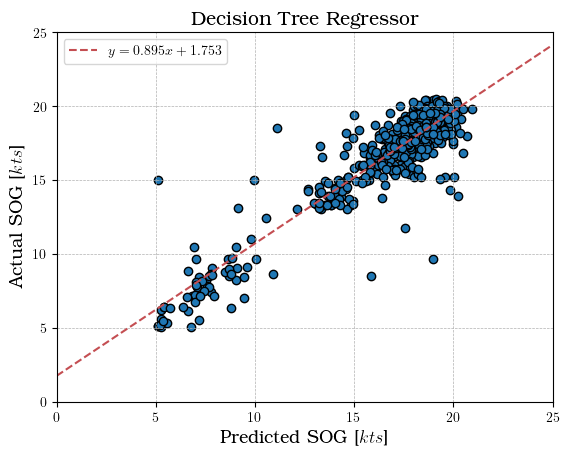

In [ ]:
pred_plot(model_dtr,'Decision Tree Regressor',x_test,y_test)
plt.show()

0.9340421345767507
y = 0.9 * x + 1.6


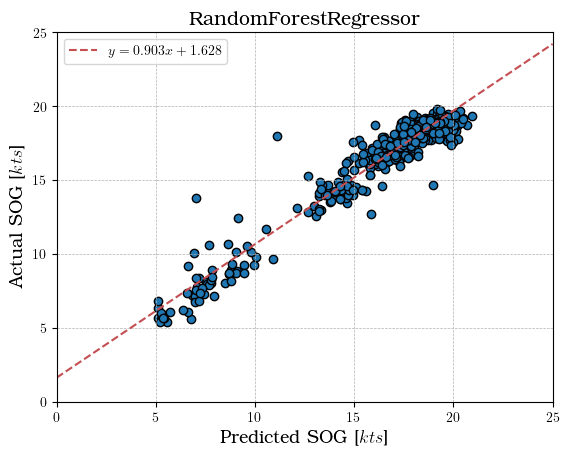

In [ ]:
pred_plot(model_rfr_ftr,'RandomForestRegressor',x_test,y_test)
plt.show()

0.9365209694167664
y = 0.9 * x + 1.5


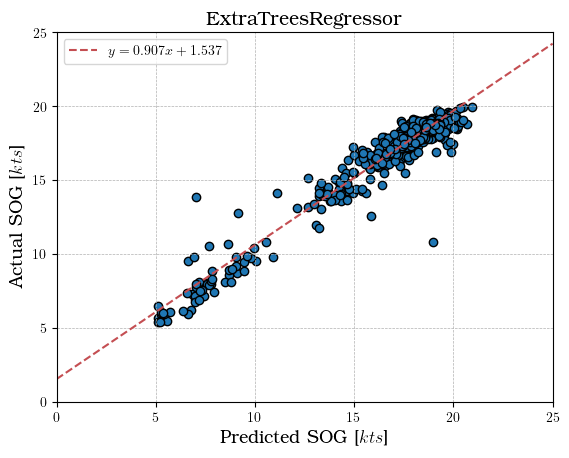

In [ ]:
pred_plot(model_etr,'ExtraTreesRegressor',x_test,y_test)
plt.show()

0.6914633407031769
y = 0.7 * x + 5.2


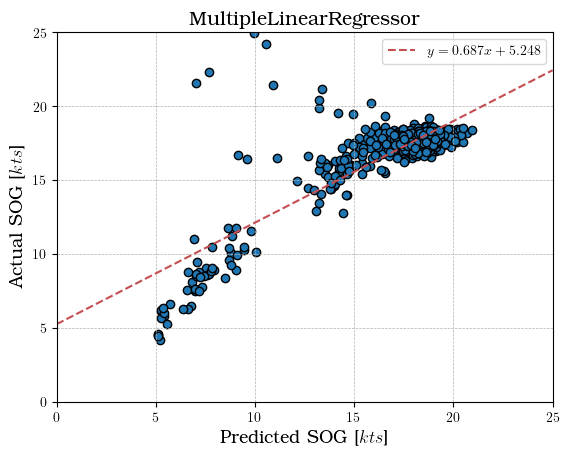

In [ ]:
pred_plot(model_mlr,'MultipleLinearRegressor',x_test,y_test)
plt.show()

Understanding the effects of different hyperparameter optimisation on model's performance

Function to plot effect of number of features on RMSE

In [ ]:
# explore random forest number of features effect on performance, v2 optimised for comparison plot between decision tree and random forest
def feature_curve(x,y,regressor,regname):
	from numpy import mean
	from numpy import std
	from sklearn.model_selection import cross_val_score
	from sklearn.model_selection import KFold

	plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})

	# get a list of models to evaluate
	def get_modelsftr():
		models_ftr = dict()
		# explore number of features from 1 to 13
		for n in range(1,13):
			if regressor == 'dt':
				models_ftr[str(n)] = DecisionTreeRegressor(max_features=n)
			elif regressor == 'rf':
				models_ftr[str(n)] = RandomForestRegressor(max_features=n)
			elif regressor == 'et':
				models_ftr[str(n)] = ExtraTreesRegressor(max_features=n)	
		return models_ftr

	# evaluate a given model using cross-validation
	def evaluate_model(model, x, y):
		# define the evaluation procedure
		cv = KFold(n_splits=10, shuffle=True, random_state=1)
		# evaluate the model and collect the results
		scores = cross_val_score(model, x, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
		# negative scores due to scoring mechanism of sklearn
		return -scores

	# get the models to evaluate
	models_ftr = get_modelsftr()
	# evaluate the models and store results
	results_ftr, names_ftr = list(), list()
	for name, model in models_ftr.items():
		# evaluate the model
		scores_ftr = evaluate_model(model, x, y)
		# store the results
		results_ftr.append(scores_ftr)
		names_ftr.append(name)
		# summarize the performance along the way
		print('>%s %.3f (%.3f)' % (name, mean(scores_ftr), std(scores_ftr)))
	
	# Calculate mean for the x value of the plot

	mean_ftr = np.mean(results_ftr,axis=1)
	min_error_ftr = np.min(mean_ftr)

	print(f"The minimum RMSE obtained is {min_error_ftr:.3f}")
	
	plt.plot(names_ftr,mean_ftr,"b.-")
	plt.grid(linestyle = '--', linewidth = 0.5)
	# plt.xlim(0,12-1)
	plt.ylim(0,5)
	plt.xlabel(r"Number of features",fontsize=13)
	plt.ylabel(r"RMSE [knots]",fontsize=13)
	plt.title(rf"{regname}", fontsize=14)
	plt.boxplot(results_ftr, labels=names_ftr,positions=range(len(names_ftr)), showmeans=True)

>1 2.892 (0.763)
>2 2.454 (0.418)
>3 2.027 (0.748)
>4 2.027 (0.409)
>5 1.948 (0.554)
>6 1.862 (0.458)
>7 2.056 (0.516)
>8 1.735 (0.597)
>9 2.052 (0.672)
>10 2.079 (0.561)
>11 1.711 (0.572)
>12 1.921 (0.676)
The minimum RMSE obtained is 1.711
>1 1.874 (0.413)
>2 1.564 (0.320)
>3 1.420 (0.316)
>4 1.320 (0.289)
>5 1.285 (0.291)
>6 1.236 (0.277)
>7 1.216 (0.283)
>8 1.181 (0.242)
>9 1.209 (0.253)
>10 1.184 (0.207)
>11 1.221 (0.260)
>12 1.226 (0.245)
The minimum RMSE obtained is 1.181


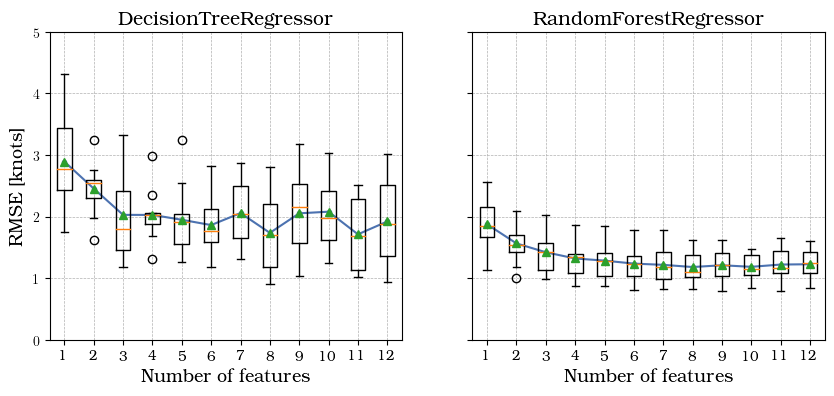

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
feature_curve(x_test,y_test,regressor='dt',regname='DecisionTreeRegressor')
plt.sca(axes[1])
feature_curve(x_test,y_test,regressor='rf',regname='RandomForestRegressor')
plt.ylabel("")
plt.show()


>1 1.846 (0.313)
>2 1.506 (0.254)
>3 1.323 (0.204)
>4 1.179 (0.175)
>5 1.116 (0.191)
>6 1.054 (0.164)
>7 1.007 (0.163)
>8 0.971 (0.146)
>9 0.957 (0.161)
>10 0.928 (0.169)
>11 0.926 (0.169)
>12 0.935 (0.171)
The minimum RMSE obtained is 0.926


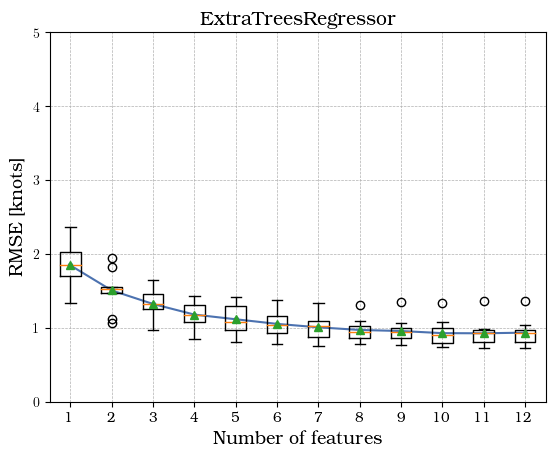

In [ ]:
feature_curve(x_test,y_test,regressor='et',regname='ExtraTreesRegressor')  
plt.show()

Explore effect of number of trees on RMSE

This is not relevant for decision tree, as we are looking into amount of trees in a forest. Decision Tree handles only with single tree.

We first explore the effect of checking the optimal amount of sample for each leaf node 

In [ ]:
# # Instead , we will invesitagte the effect of setting the minimal samples leaf
# def leaf_curve(x,y,regressor,regname):
# 	from numpy import mean
# 	from numpy import std
# 	from sklearn.model_selection import cross_val_score

# 	plt.rcParams.update({
# 	"text.usetex": True,
# 	"font.family": "serif",
# 	"font.serif": "bookman",
# 	})

# 	# get a list of models to evaluate
# 	def get_models_leaf():
# 		models_leaf = dict()
# 		# define number of trees to consider
# 		n_samples_leaf = [1,2,3,4,5,6,7,8,9,10,50]
# 		for n in n_samples_leaf:
# 			if regressor == 'dt':
# 				models_leaf[str(n)] = DecisionTreeRegressor(min_samples_leaf = n)
# 			if regressor == 'rf':
# 				models_leaf[str(n)] = RandomForestRegressor(min_samples_leaf = n)
# 			if regressor == 'et':
# 				models_leaf[str(n)] = ExtraTreesRegressor(min_samples_leaf = n)
# 		return models_leaf

# 	# evaluate a given model using cross-validation
# 	def evaluate_model(model, x, y):
# 		scores = cross_val_score(model, x, y, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)
# 		return -scores

# 	# # define dataset
# 	# get the models to evaluate
# 	models_leaf = get_models_leaf()

# 	# evaluate the models and store results
# 	results_leaf, names_leaf = list(), list()
# 	for name, model in models_leaf.items():
# 		# evaluate the model
# 		scores_leaf = evaluate_model(model, x, y)
# 		# store the results
# 		results_leaf.append(scores_leaf)
# 		names_leaf.append(name)
# 		# summarize the performance along the way
# 		print('>%s %.3f (%.3f)' % (name, mean(scores_leaf), std(scores_leaf)))


# 	mean_leaf = np.mean(results_leaf,axis=1)
# 	min_error_leaf = np.min(mean_leaf)
# 	print(min_error_leaf)
# 	bst_n_estimators_leaf = np.argmin(mean_leaf)
# 	print(f"The minimum RMSE obtained is {min_error_leaf:.3f}")
# 	plt.plot(names_leaf,mean_leaf,"b.-")
# 	plt.grid(linestyle = '--', linewidth = 0.5)
# 	# plt.xlim(0,12-1)
# 	plt.ylim(0,5)
# 	plt.xlabel(r"Number of Samples in Leaf",fontsize=13)
# 	plt.ylabel(r"RMSE [knots]",fontsize=13)
# 	plt.title(rf"{regname}", fontsize=14)
# 	plt.boxplot(results_leaf, labels=names_leaf,positions=range(len(names_leaf)), showmeans=True)

>1 1.900 (0.582)
>2 1.761 (0.522)
>3 1.632 (0.456)
>4 1.583 (0.372)
>5 1.630 (0.421)
>6 1.647 (0.400)
>7 1.672 (0.391)
>8 1.737 (0.500)
>9 1.706 (0.473)
>10 1.763 (0.420)
>50 2.450 (0.336)
1.583355316385531
The minimum RMSE obtained is 1.583
>1 1.161 (0.235)
>2 1.168 (0.192)
>3 1.184 (0.229)
>4 1.204 (0.214)
>5 1.277 (0.222)
>6 1.291 (0.214)
>7 1.296 (0.201)
>8 1.377 (0.218)
>9 1.390 (0.208)
>10 1.403 (0.217)
>50 2.344 (0.289)
1.1605114981984355
The minimum RMSE obtained is 1.161
>1 0.926 (0.203)
>2 0.937 (0.199)
>3 1.005 (0.220)
>4 1.081 (0.212)
>5 1.152 (0.233)
>6 1.218 (0.254)
>7 1.294 (0.237)
>8 1.320 (0.239)
>9 1.356 (0.248)
>10 1.374 (0.243)
>50 2.317 (0.379)
0.9255761432839493
The minimum RMSE obtained is 0.926


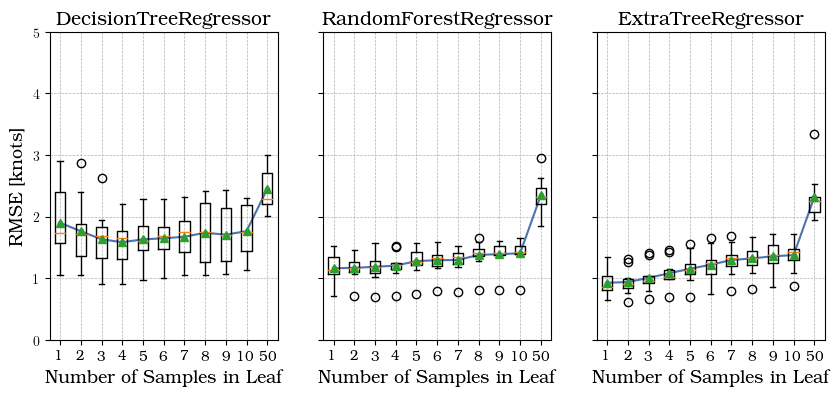

In [ ]:
# fig, axes = plt.subplots(ncols=3, figsize=(10, 4), sharey=True)
# plt.sca(axes[0])
# leaf_curve(x_test,y_test,regressor='dt',regname='DecisionTreeRegressor')
# plt.sca(axes[1])
# leaf_curve(x_test,y_test,regressor='rf',regname='RandomForestRegressor')
# plt.ylabel("")
# plt.sca(axes[2])
# leaf_curve(x_test,y_test,regressor='et',regname='ExtraTreeRegressor')
# plt.ylabel("")
# plt.show()

In [ ]:
# # explore random forest and extra tree number of trees effect on performance
# def trees_curve(x,y,regressor,regname):
# 	from numpy import mean
# 	from numpy import std
# 	from sklearn.model_selection import cross_val_score

# 	plt.rcParams.update({
# 	"text.usetex": True,
# 	"font.family": "serif",
# 	"font.serif": "bookman",
# 	})

# 	# get a list of models to evaluate
# 	def get_models_tree():
# 		models_tree = dict()
# 		# define number of trees to consider
# 		n_trees = [1,10,100,200,300,400,500,600,700,800,900,1000]
# 		for n in n_trees:
# 			if regressor == 'rf':
# 				models_tree[str(n)] = RandomForestRegressor(n_estimators = n)
# 			elif regressor == 'et':
# 				models_tree[str(n)] = ExtraTreesRegressor(n_estimators = n)	
# 		return models_tree

# 	# evaluate a given model using cross-validation
# 	def evaluate_model(model_tree, x, y):
# 		scores = cross_val_score(model, x, y, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)
# 		return -scores

# 	# # define dataset
# 	# get the models to evaluate
# 	models_tree = get_models_tree()

# 	# evaluate the models and store results
# 	results_tree, names_tree = list(), list()
# 	for name, model in models_tree.items():
# 		# evaluate the model
# 		scores_tree = evaluate_model(model, x, y)
# 		# store the results
# 		results_tree.append(scores_tree)
# 		names_tree.append(name)
# 		# summarize the performance along the way
# 		print('>%s %.3f (%.3f)' % (name, mean(scores_tree), std(scores_tree)))


# 	mean_tree = np.mean(results_tree,axis=1)
# 	min_error_tree = np.min(mean_tree)
# 	print(min_error_tree)
# 	print(f"The minimum RMSE obtained is {min_error_tree:.3f}")
# 	plt.plot(names_tree,mean_tree,"b.-")
# 	plt.grid(linestyle = '--', linewidth = 0.5)
# 	# plt.xlim(0,12-1)
# 	plt.ylim(0,5)
# 	plt.xlabel(r"Number of Trees", fontsize=13)
# 	plt.ylabel(r"RMSE [knots]", fontsize=13)
# 	plt.title(rf"{regname}", fontsize=14)
# 	pyplot.boxplot(results_tree, labels=names_tree, showmeans=True,positions=range(len(names_tree)))


>1 2.027 (0.533)
>10 1.266 (0.259)
>100 1.190 (0.227)
>200 1.175 (0.224)
>300 1.187 (0.225)
>400 1.190 (0.226)
>500 1.190 (0.231)
>600 1.176 (0.228)
>700 1.173 (0.228)
>800 1.186 (0.228)
>900 1.172 (0.223)
>1000 1.181 (0.235)
1.1717108429963654
The minimum RMSE obtained is 1.172
>1 1.619 (0.392)
>10 1.034 (0.209)
>100 0.924 (0.181)
>200 0.926 (0.197)
>300 0.923 (0.197)
>400 0.921 (0.193)
>500 0.923 (0.195)
>600 0.914 (0.188)
>700 0.918 (0.188)
>800 0.921 (0.197)
>900 0.917 (0.192)
>1000 0.918 (0.193)
0.9136324246538183
The minimum RMSE obtained is 0.914


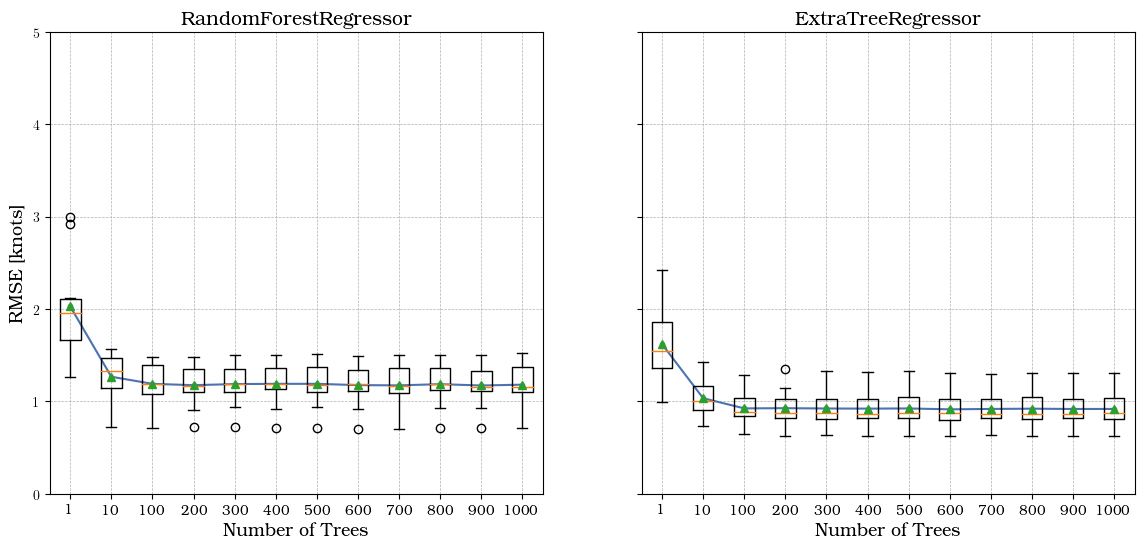

In [ ]:
# fig, axes = plt.subplots(ncols=2, figsize=(14, 6), sharey=True)
# plt.sca(axes[0])
# trees_curve(x_test,y_test,regressor='rf',regname='RandomForestRegressor')
# plt.sca(axes[1])
# trees_curve(x_test,y_test,regressor='et',regname='ExtraTreeRegressor')
# plt.ylabel("")
# plt.show()

Explore effect of tree depth on RMSE

In [ ]:
# # explore tree based , tree depth. effect on performance
# def depth_curve(x,y,regressor,regname):
# 	from numpy import mean
# 	from numpy import std
# 	from sklearn.model_selection import cross_val_score
# 	from sklearn.model_selection import KFold

# 	# Parameter to plot in nice latex font

# 	plt.rcParams.update({
# 	"text.usetex": True,
# 	"font.family": "serif",
# 	"font.serif": "bookman",
# 	})

# 	# get a list of models to evaluate
# 	def get_models_dp():
# 		models_dp = dict()
# 		# consider tree depths from 1 to 7 and None=full
# 		depths = [1,2,3,4,5,6,7,8,9,10,100] + [None]
# 		for n in depths:
# 			if regressor == 'dt':
# 				models_dp[str(n)] = DecisionTreeRegressor(max_depth=n)
# 			elif regressor == 'rf':
# 				models_dp[str(n)] = RandomForestRegressor(max_depth=n)
# 			elif regressor == 'et':
# 				models_dp[str(n)] = ExtraTreesRegressor(max_depth=n)	
# 		return models_dp

# 	# evaluate a given model using cross-validation
# 	def evaluate_model(model, x, y):
# 		# define the evaluation procedure
# 		cv = KFold(n_splits=10, shuffle=True, random_state=1)
# 		# evaluate the model and collect the results
# 		scores = cross_val_score(model, x, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# 		# negative scores due to scoring mechanism of sklearn
# 		return -scores

# 	# get the models to evaluate
# 	models_dp = get_models_dp()
# 	# evaluate the models and store results
# 	results_dp, names_dp = list(), list()
# 	for name, model in models_dp.items():
# 		# evaluate the model
# 		scores_dp = evaluate_model(model, x, y)
# 		# store the results
# 		results_dp.append(scores_dp)
# 		names_dp.append(name)
# 		# summarize the performance along the way
# 		print('>%s %.3f (%.3f)' % (name, mean(scores_dp), std(scores_dp)))


# 	mean_dp = np.mean(results_dp,axis=1)
# 	min_error_dp = np.min(mean_dp)
# 	print(min_error_dp)
# 	bst_n_estimators_dp= np.argmin(mean_dp)
# 	print(f"The minimum RMSE obtained is {min_error_dp:.3f}")
# 	plt.plot(names_dp,mean_dp,"b.-")
# 	plt.grid(linestyle = '--', linewidth = 0.5)
# 	plt.ylim(0,5)
# 	plt.xlabel(r"Tree Depth",fontsize=13)
# 	plt.ylabel(r"RMSE [knots]",fontsize=13)
# 	plt.title(rf"{regname}", fontsize=14)
# 	plt.boxplot(results_dp, labels=names_dp,positions=range(len(names_dp)), showmeans=True)

>1 3.090 (0.522)
>2 3.055 (0.475)
>3 2.432 (0.530)
>4 2.158 (0.599)
>5 1.935 (0.724)
>6 1.856 (0.783)
>7 1.764 (0.679)
>8 1.800 (0.576)
>9 1.795 (0.663)
>10 1.862 (0.615)
>100 1.906 (0.648)
>None 1.883 (0.652)
1.7644904830360466
The minimum RMSE obtained is 1.764
>1 3.015 (0.514)
>2 2.506 (0.468)
>3 1.823 (0.391)
>4 1.527 (0.329)
>5 1.363 (0.310)
>6 1.285 (0.242)
>7 1.271 (0.257)
>8 1.247 (0.275)
>9 1.244 (0.243)
>10 1.225 (0.231)
>100 1.258 (0.268)
>None 1.239 (0.253)
1.2249476183578873
The minimum RMSE obtained is 1.225


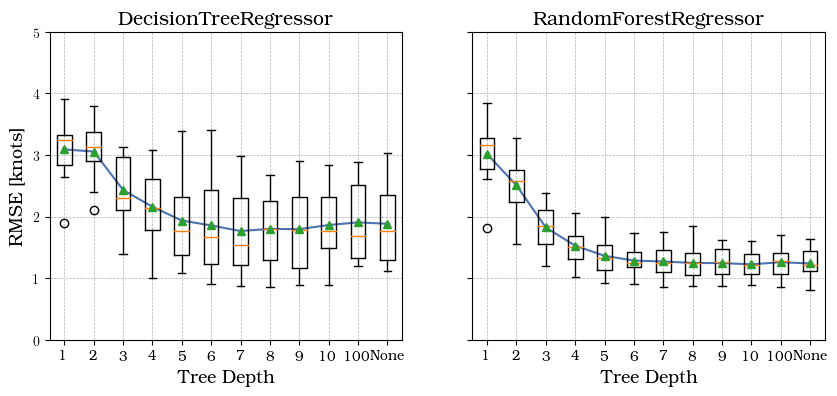

In [ ]:
# fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
# plt.sca(axes[0])
# depth_curve(x_test,y_test,regressor='dt',regname='DecisionTreeRegressor')
# plt.sca(axes[1])
# depth_curve(x_test,y_test,regressor='rf',regname='RandomForestRegressor')
# plt.ylabel("")
# plt.show()

>1 3.042 (0.561)
>2 2.304 (0.383)
>3 1.715 (0.254)
>4 1.384 (0.234)
>5 1.199 (0.212)
>6 1.079 (0.201)
>7 1.023 (0.171)
>8 0.996 (0.202)
>9 0.964 (0.193)
>10 0.940 (0.169)
>100 0.927 (0.177)
>None 0.926 (0.176)
0.9259599713851252
The minimum RMSE obtained is 0.926


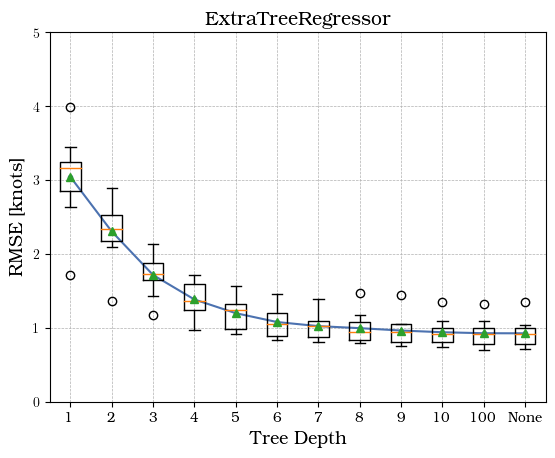

In [ ]:
# depth_curve(x_test,y_test,regressor='et',regname='ExtraTreeRegressor')
# plt.show()

Explore amount of samples required to split a data 

In [ ]:
# # explore tree based , tree depth. effect on performance
# def split_curve(x,y,regressor,regname):
# 	from numpy import mean
# 	from numpy import std
# 	from sklearn.model_selection import cross_val_score
# 	from sklearn.model_selection import KFold

# 	# Parameter to plot in nice latex font

# 	plt.rcParams.update({
# 	"text.usetex": True,
# 	"font.family": "serif",
# 	"font.serif": "bookman",
# 	})

# 	# get a list of models to evaluate
# 	def get_models_sp():
# 		models_sp = dict()
# 		# consider tree depths from 1 to 7 and None=full
# 		split = [1,2,3,4,5,6,7,8,9,10,50,100]
# 		for n in split:
# 			if regressor == 'dt':
# 				models_sp[str(n)] = DecisionTreeRegressor(max_depth=n)
# 			elif regressor == 'rf':
# 				models_sp[str(n)] = RandomForestRegressor(max_depth=n)
# 			elif regressor == 'et':
# 				models_sp[str(n)] = ExtraTreesRegressor(max_depth=n)	
# 		return models_sp

# 	# evaluate a given model using cross-validation
# 	def evaluate_model(model, x, y):
# 		# define the evaluation procedure
# 		cv = KFold(n_splits=10, shuffle=True, random_state=1)
# 		# evaluate the model and collect the results
# 		scores = cross_val_score(model, x, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# 		# negative scores due to scoring mechanism of sklearn
# 		return -scores

# 	# get the models to evaluate
# 	models_sp = get_models_sp()
# 	# evaluate the models and store results
# 	results_sp, names_sp = list(), list()
# 	for name, model in models_sp.items():
# 		# evaluate the model
# 		scores_sp = evaluate_model(model, x, y)
# 		# store the results
# 		results_sp.append(scores_sp)
# 		names_sp.append(name)
# 		# summarize the performance along the way
# 		print('>%s %.3f (%.3f)' % (name, mean(scores_sp), std(scores_sp)))


# 	mean_sp = np.mean(results_sp,axis=1)
# 	min_error_sp = np.min(mean_sp)
# 	print(min_error_sp)
# 	bst_n_estimators_sp= np.argmin(mean_sp)
# 	print(f"The minimum RMSE obtained is {min_error_sp:.3f}")
# 	plt.plot(names_sp,mean_sp,"b.-")
# 	plt.grid(linestyle = '--', linewidth = 0.5)
# 	plt.ylim(0,5)
# 	plt.xlabel(r"Minimum Sample to split ",fontsize=13)
# 	plt.ylabel(r"RMSE [knots]",fontsize=13)
# 	plt.title(rf"{regname}", fontsize=14)
# 	plt.boxplot(results_sp, labels=names_sp,positions=range(len(names_sp)), showmeans=True)

>1 3.090 (0.522)
>2 3.055 (0.475)
>3 2.432 (0.530)
>4 2.089 (0.664)
>5 1.925 (0.748)
>6 1.853 (0.777)
>7 1.778 (0.649)
>8 1.886 (0.642)
>9 1.794 (0.618)
>10 1.880 (0.644)
>50 1.878 (0.657)
>100 1.912 (0.571)
1.7781124798582737
The minimum RMSE obtained is 1.778
>1 3.006 (0.518)
>2 2.490 (0.431)
>3 1.824 (0.373)
>4 1.542 (0.315)
>5 1.372 (0.298)
>6 1.302 (0.249)
>7 1.276 (0.246)
>8 1.248 (0.254)
>9 1.252 (0.264)
>10 1.240 (0.247)
>50 1.229 (0.258)
>100 1.229 (0.247)
1.2290350018327751
The minimum RMSE obtained is 1.229


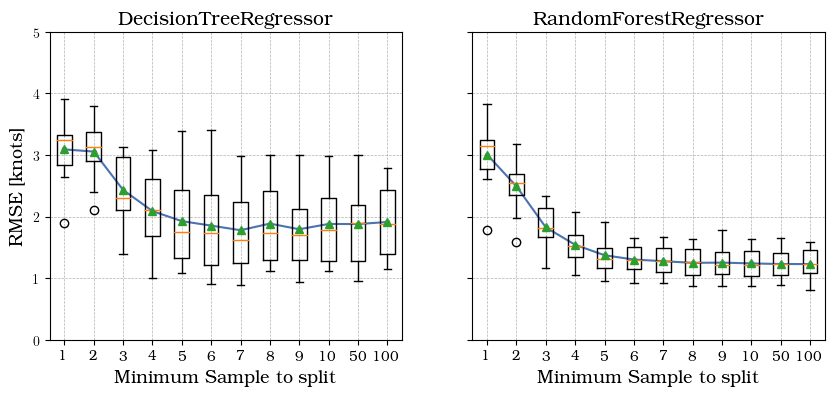

In [ ]:
# fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
# plt.sca(axes[0])
# split_curve(x_test,y_test,regressor='dt',regname='DecisionTreeRegressor')
# plt.sca(axes[1])
# split_curve(x_test,y_test,regressor='rf',regname='RandomForestRegressor')
# plt.ylabel("")
# plt.show()

>1 3.043 (0.566)
>2 2.306 (0.387)
>3 1.726 (0.260)
>4 1.345 (0.232)
>5 1.205 (0.216)
>6 1.096 (0.196)
>7 1.024 (0.206)
>8 0.987 (0.197)
>9 0.951 (0.182)
>10 0.928 (0.173)
>50 0.946 (0.175)
>100 0.933 (0.178)
0.9282848346770642
The minimum RMSE obtained is 0.928


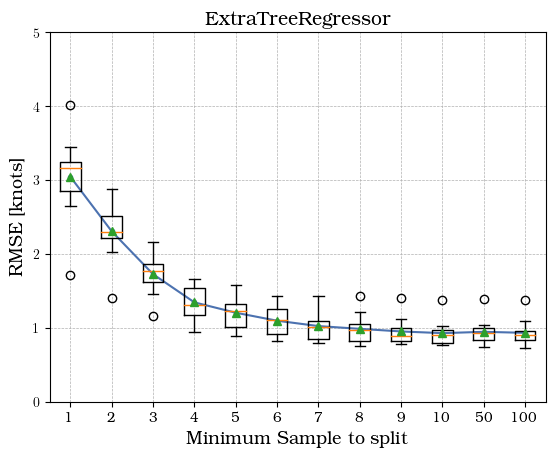

In [ ]:
# split_curve(x_test,y_test,regressor='et',regname='ExtraTreeRegressor')
# plt.show()

Learning Curves

In [ ]:
# Functions for RMSE and Rsquared plots
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit ,learning_curve

def learn_plotrmse(model,x_data,y_data,model_name):
    train_sizes, train_scores, test_scores = learning_curve(estimator = model, X=x_data, y=y_data,
                                                        cv=5, train_sizes=np.linspace(0.1, 1.0, 20),
                                                        n_jobs=-1,scoring="neg_root_mean_squared_error")
	# Parameter to plot in nice latex fonts
    plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
    #
    # Calculate training and test mean and std
    #
    train_mean = -np.mean(train_scores, axis=1)
    train_std = -np.std(train_scores, axis=1)
    test_mean = -np.mean(test_scores, axis=1)
    test_std = -np.std(test_scores, axis=1)
    #
    # Plot the learning curve
    #
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label=r'Training Error')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='d', markersize=5, linestyle='--', label=r'Validation Error')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title(fr'Learning Curve of {model_name}')
    plt.xlabel(r'Training Data Size')
    plt.ylabel(r'RMSE [knots]')
    plt.ylim(0,2)
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.legend(loc='lower right')
    # plt.show()
def learn_plotr2(model,x_data,y_data,model_name):
    train_sizes, train_scores, test_scores = learning_curve(estimator = model, X=x_data, y=y_data,
                                                        cv=5, train_sizes=np.linspace(0.1, 1.0, 20),
                                                        n_jobs=-1,scoring="r2")
	# Parameter to plot in nice latex fonts
    plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
    #
    # Calculate training and test mean and std
    #
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    #
    # Plot the learning curve
    #
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label=r'Training Score')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='d', markersize=5, linestyle='--', label=r'Validation Score')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title(fr'Learning Curve of {model_name}')
    plt.xlabel(r'Training Data Size')
    plt.ylabel(r'Rsquared')
    plt.ylim(0.5,1)
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.legend(loc='lower right')
    # plt.show()


Understanding Effect of Hyperparameter optimisation

Learning Curve DTR

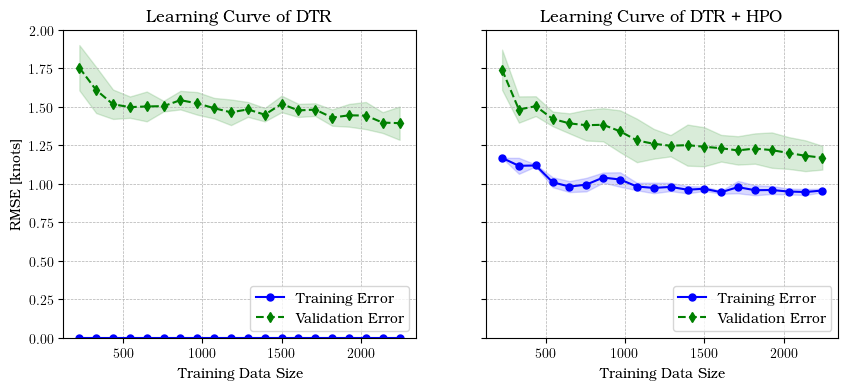

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
learn_plotrmse(model_dtr,x_train,y_train,'DTR')
plt.sca(axes[1])
learn_plotrmse(model_dtr_hpov,x_train,y_train,'DTR + HPO')
plt.ylabel("")
plt.show()

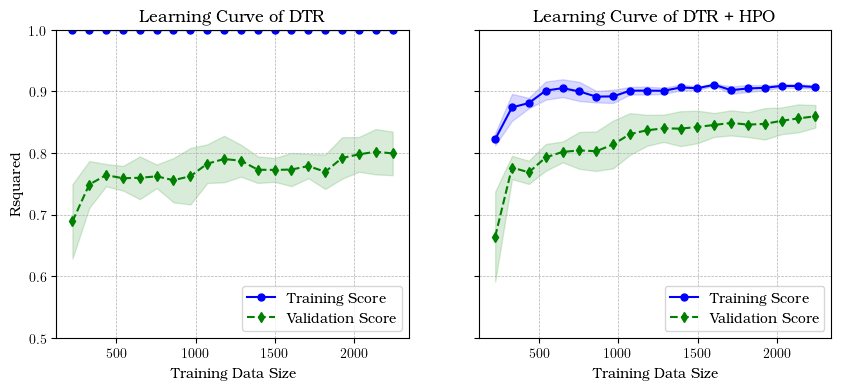

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
learn_plotr2(model_dtr,x_train,y_train,'DTR')
plt.sca(axes[1])
learn_plotr2(model_dtr_hpov,x_train,y_train,'DTR + HPO')
plt.ylabel("")
plt.show()

Learning Curve RFR

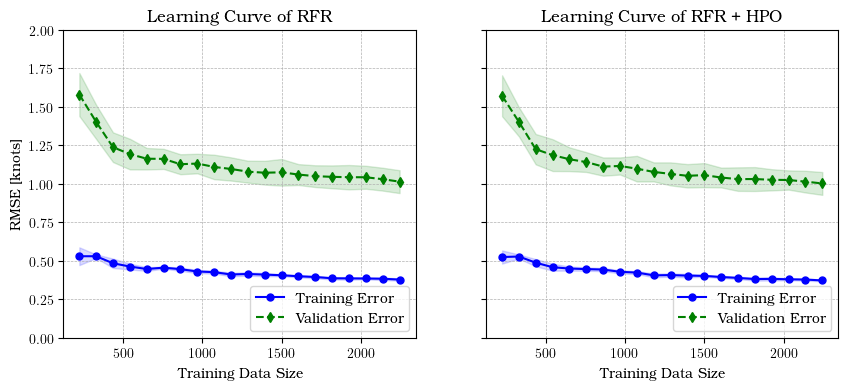

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
learn_plotrmse(model_rfr_ftr,x_train,y_train,'RFR')
plt.sca(axes[1])
learn_plotrmse(model_rfr_ftr_hpov,x_train,y_train,'RFR + HPO')
plt.ylabel("")
plt.show()

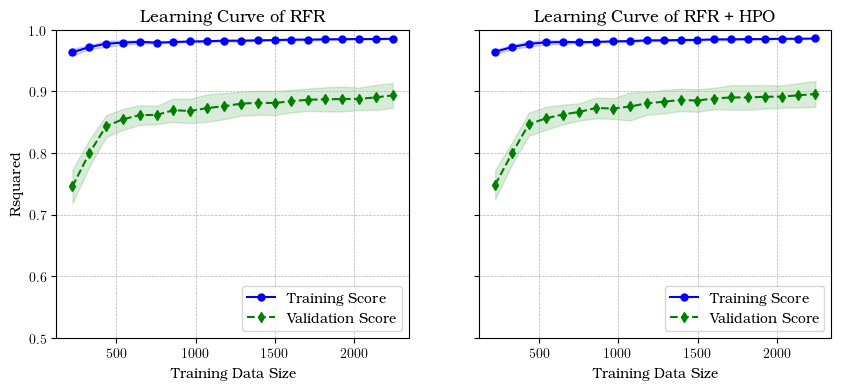

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
learn_plotr2(model_rfr_ftr,x_train,y_train,'RFR')
plt.sca(axes[1])
learn_plotr2(model_rfr_ftr_hpov,x_train,y_train,'RFR + HPO')
plt.ylabel("")
plt.show()

Learning Curve ETR

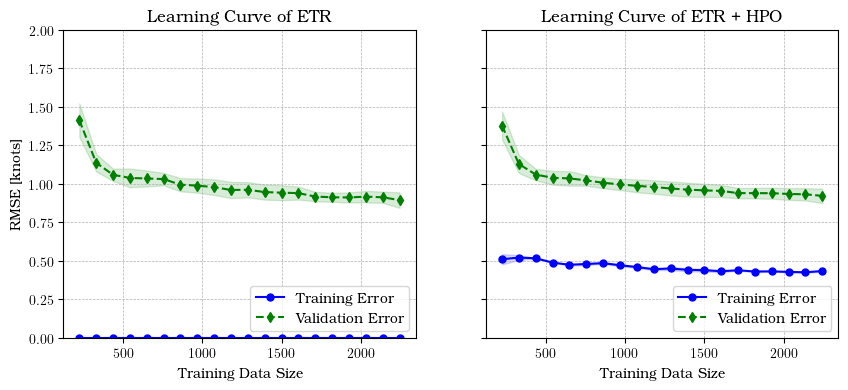

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
learn_plotrmse(model_etr,x_train,y_train,'ETR')
plt.sca(axes[1])
learn_plotrmse(model_etr_hpov,x_train,y_train,'ETR + HPO')
plt.ylabel("")
plt.show()

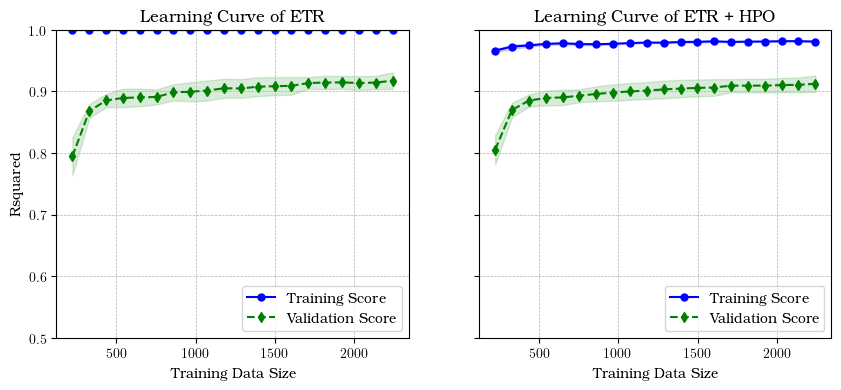

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
learn_plotr2(model_etr,x_train,y_train,'ETR')
plt.sca(axes[1])
learn_plotr2(model_etr_hpov,x_train,y_train,'ETR + HPO')
plt.ylabel("")
plt.show()

Box plot for evaluations

<Figure size 500x300 with 0 Axes>

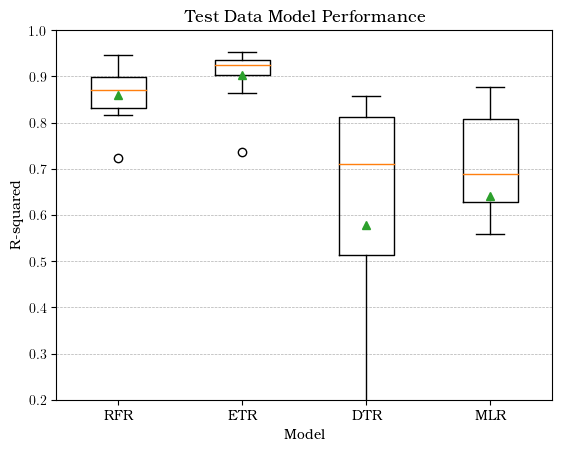

In [ ]:
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
scores = [r2_rf,r2_et,r2_dt,r2_mlr]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title("Test Data Model Performance")
plt.ylabel("R-squared")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(0.2,1.0)
plt.boxplot(scores,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['RFR', 'ETR',
                    'DTR', 'MLR'])
plt.show()

<Figure size 500x300 with 0 Axes>

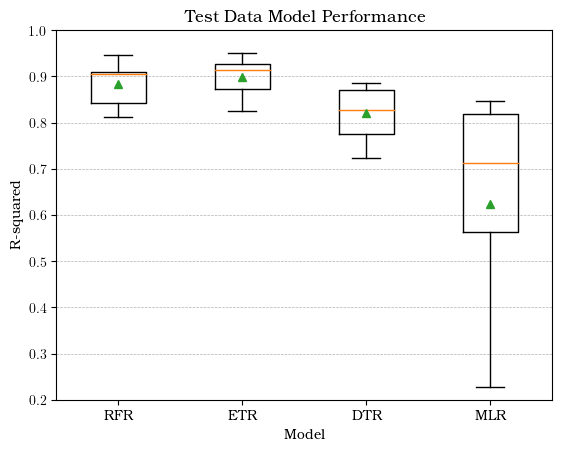

In [ ]:
# # Test combined test data 

# plt.rcParams.update({
# 	"text.usetex": True,
# 	"font.family": "serif",
# 	"font.serif": "bookman",
# 	})
# scores = [r2_rfc,r2_etc,r2_dtc,r2_mlrc]
# fig = plt.figure(figsize=(5,3))
# # Creating axes instance
# # ax = fig.add_axes([0, 0, 1, 1])
# fig,ax = plt.subplots()
# plt.title("Test Data Model Performance")
# plt.ylabel("R-squared")
# plt.xlabel("Model")
# plt.yscale('linear')
# plt.ylim(0.2,1.0)
# plt.boxplot(scores,showmeans=True)
# plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
# ax.set_xticklabels(['RFR', 'ETR',
#                     'DTR', 'MLR'])
# plt.show()

<Figure size 500x300 with 0 Axes>

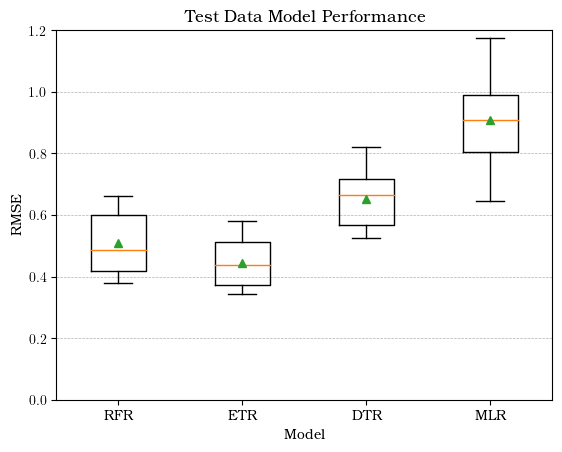

In [ ]:
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
scores_rmse = [np.abs(RMSE_rf),np.abs(RMSE_et),np.abs(RMSE_dt),np.abs(RMSE_mlr)]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
fig,ax = plt.subplots() 
plt.title("Test Data Model Performance")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.ylim(0,1.2)
plt.yscale('linear')
ax.boxplot(scores_rmse,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['RFR', 'ETR',
                    'DTR', 'MLR'])
plt.show()

<Figure size 500x300 with 0 Axes>

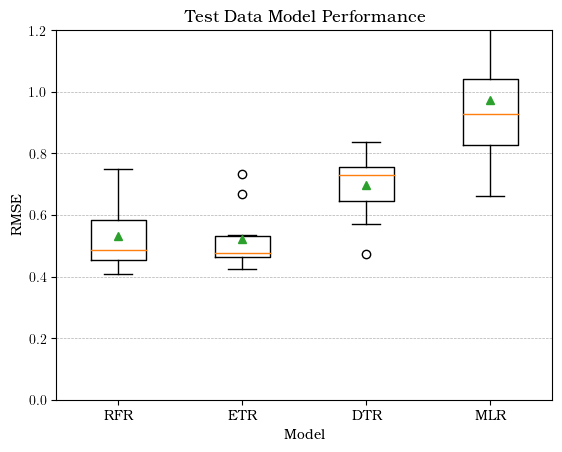

In [ ]:
# plt.rcParams.update({
# 	"text.usetex": True,
# 	"font.family": "serif",
# 	"font.serif": "bookman",
# 	})
# scores_rmse = [np.abs(RMSE_rfc),np.abs(RMSE_etc),np.abs(RMSE_dtc),np.abs(RMSE_mlrc)]
# fig = plt.figure(figsize=(5,3))
# # Creating axes instance
# fig,ax = plt.subplots() 
# plt.title("Test Data Model Performance")
# plt.ylabel("RMSE")
# plt.xlabel("Model")
# plt.ylim(0,1.2)
# plt.yscale('linear')
# ax.boxplot(scores_rmse,showmeans=True)
# plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
# ax.set_xticklabels(['RFR', 'ETR',
#                     'DTR', 'MLR'])
# plt.show()